### Imports

In [1361]:
import numpy as np
import torch
import seaborn as sns
import random
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import copy
import glob
import os
import pickle
from invoke import run
from scipy.stats import mannwhitneyu

# Loading results

In [3492]:
def get_analysis_all_models_results(conf):
    analysis_all_models_results = []
    all_models = list(itertools.product(
        conf['all_train_types'],conf['cps'],conf['all_train_sizes'], conf['all_conds'], conf['all_text_types'], conf['is_with_eos'], conf['wrong_compute_type']))
    
    for train_type, cp, train_size, conds, text_type, is_with_eos, wrong_compute_type in all_models:
        if 'zero_attn' not in conf.keys():
            if 'zero_attn' in train_type:
                zero_out_samples = "_True"
            else:
                zero_out_samples = "_False"
        else:
            zero_out_samples = ""
        if (text_type == "natural" and conds[0] == "s_np_vp") or (text_type == "semi_natural" and conds[1] == "vp_prime"):
            continue
        results_file_name = f"results_{train_type}{cp}_{train_size}_{text_type}_{conds[0]}_{conds[1]}_{conf['seed']}_{conf['template']}_{conf['recompte_avg_attn_mat']}{is_with_eos}_False_False{zero_out_samples}{wrong_compute_type}"
        try:
            results_file = torch.load(conf['analysis_results_dir']+results_file_name+'.pt')
            df_from_result_file = pd.DataFrame.from_dict(results_file)
            df_from_result_file['wrong_compute_type'] = wrong_compute_type
            analysis_all_models_results.append(df_from_result_file) 
        except Exception as e:
            #print(str(e).replace("[Errno 2] No such file or directory: '/checkpoint/itayitzhak/attn_weigths/results/results_",""))
            #print(e)
            print(results_file_name.replace("/checkpoint/itayitzhak/attn_weigths/results/results_",""))
            print(f"Logs are in :/checkpoint/itayitzhak/projects/globality/{results_file_name}/submitit_logs/")
            print("="*80)
    analysis_all_models_results = pd.concat(analysis_all_models_results)
    
    return analysis_all_models_results

In [3499]:
################### remove_eos_not_permuted (Basline) ###################

# conf = {"analysis_results_dir": '/checkpoint/itayitzhak/attn_weigths/results/',
#         "recompte_avg_attn_mat":'True',
#         "is_with_eos":['_True'],
#         "seed":"1,2,3,4,5",
#         "template":"1,2,3,4,5,6,7,8,9,10",
#         "cps":[""],
#         "wrong_compute_type":[""],
#         "all_train_types": ["remove_eos_not_permuted"],
#         "all_train_sizes": ['tiny','small', 'all'],
#         "all_text_types": ['synthetic',"semi_natural","natural"],
#         "all_conds": zip(["s_conj","s_conj","s_conj"], ["s1_s2","s1p_s2","s3_s2"]),
#         #"all_conds": zip(["s_conj","s_conj","s_conj","s_np_vp","s_np_vp","s_np_vp"], ["s1_s2","s1p_s2","s3_s2",'np',"np_prime","vp_prime"]),
# }

###################  not_permuted (Basline) ###################

# conf = {"analysis_results_dir": '/checkpoint/itayitzhak/attn_weigths/results/',
#         "recompte_avg_attn_mat":'True',
#         "is_with_eos":['_True'],
#         "seed":"1,2,3,4,5",
#         "template":"1,2,3,4,5,6,7,8,9,10",
#         "cps":[""],
#         "wrong_compute_type":[""],
#         "all_train_types": ["not_permuted"],
#         "all_train_sizes": ['tiny','small', 'all'],
#         "all_text_types": ['synthetic',"semi_natural","natural"],
#         "all_conds": zip(["s_conj","s_conj","s_conj"], ["s1_s2","s1p_s2","s3_s2"]),
#         #"all_conds": zip(["s_conj","s_conj","s_conj","s_np_vp","s_np_vp","s_np_vp"], ["s1_s2","s1p_s2","s3_s2",'np',"np_prime","vp_prime"]),
# }

# conf = {"analysis_results_dir": '/checkpoint/itayitzhak/attn_weigths/results/',
#         "recompte_avg_attn_mat":'True',
#         "is_with_eos":['_False'],
#         "seed":"1,2,3,4,5",
#         "template":"1,2,3,4,5,6,7,8,9,10",
#         "cps":[""],
#         "wrong_compute_type":[""],
#         "all_train_types": ["not_permuted"],
#         "all_train_sizes": ['tiny','small', 'all'],
#         "all_text_types": ['synthetic',"semi_natural","natural"],
#         "all_conds": zip(["s_conj","s_conj","s_conj"], ["s1_s2","s1p_s2","s3_s2"]),
#         #"all_conds": zip(["s_conj","s_conj","s_conj","s_np_vp","s_np_vp","s_np_vp"], ["s1_s2","s1p_s2","s3_s2",'np',"np_prime","vp_prime"]),
# }

#################### checkpoints ###################

conf = {"analysis_results_dir": '/checkpoint/itayitzhak/attn_weigths/results/',
        "recompte_avg_attn_mat":'True',
        "is_with_eos":['_True'],
        "wrong_compute_type":[""],
        "seed":"1,2,3,4,5",
        "template":"1",
        "cps":["_cp_1-17"],
        "all_train_types": ["remove_eos_not_permuted"],
        #"all_train_sizes": ['small'],
        "all_train_sizes": ['all'],
        "all_text_types": ['synthetic'],
        "all_conds": zip(["s_conj","s_conj","s_conj"], ["s1_s2","s1p_s2","s3_s2"]),
}


#################### Wrong compute ###################

# conf = {"analysis_results_dir": '/checkpoint/itayitzhak/attn_weigths/results/',
#         "recompte_avg_attn_mat":'True',
#         "is_with_eos":['_True'],
#         "seed":"1,2,3,4,5",
#         "template":"1,2,3,4,5,6,7,8,9,10",
#         "cps":[""],
#         "wrong_compute_type":["permute"], # "wrong_compute_type":["one_weight"], #"wrong_compute_type":[""],
#         "all_train_types": ["remove_eos_not_permuted"],
#         "all_train_sizes": ['tiny','small', 'all'],
#         "all_text_types": ['synthetic',"semi_natural","natural"],
#         "all_conds": zip(["s_conj","s_conj","s_conj"], ["s1_s2","s1p_s2","s3_s2"]),
# }


#################### adapted spans ###################

# conf = {"analysis_results_dir": '/checkpoint/itayitzhak/attn_weigths/results/',
#         "recompte_avg_attn_mat":'True',
#         "is_with_eos":['_True'],
#         "seed":"1,2,3,4,5",
#         "template":"1,2,3,4,5,6,7,8,9,10",
#         "cps":[""],
#         "all_train_types": [#"remove_eos_not_permuted",
# #                             "adspan_2_local_layers_remove_eos",
# #                             "adspan_after_sm_cone_remove_eos",
# #             "adspan_before_sm_3_global_layers_remove_eos",
# #                            "adspan_after_sm_3_global_layers_remove_eos",
# #                             "adspan_after_sm_global_004567_remove_eos",
# #                             "adspan_after_sm_local_321000_global_000555_remove_eos",
# #                             "adspan_after_sm_global_006666_remove_eos",
#                             "load_all_attn_remove_eos",
#                             "load_all_attn_nfreeze_remove_eos",
#                            ],
#         #"all_train_types": ["adspan_2_local_layers_remove_eos"],
#         "all_train_sizes": ['tiny'],
#         #"all_text_types": ['synthetic',"semi_natural","natural"],
#         "all_text_types": ['synthetic'],
#         "all_conds": zip(["s_conj","s_conj","s_conj"], ["s1_s2","s1p_s2","s3_s2"]),
# }


#################### attention head dropout ###################

# conf = {"analysis_results_dir": '/checkpoint/itayitzhak/attn_weigths/results/',
#         "recompte_avg_attn_mat":'True',
#         #"is_with_eos":['_True', ''],
#         "is_with_eos":['_True'],
#         "seed":"1,2,3,4,5",
#         "template":"1,2,3,4,5,6,7,8,9,10",
#         "cps":[""],
#         # "all_train_types": ["remove_eos_not_permuted"],
#         #"all_train_types": ["not_permuted"],
#         #"all_train_types": ["remove_eos_not_permuted","ahd_0_1_remove_eos","ahd_0_3_remove_eos"],
#         "all_train_types": ["ahd_0_1_remove_eos"],
#         #"all_train_sizes": ['all', 'small', 'tiny'],
#         "all_train_sizes": ['tiny','small'],
#         "all_text_types": ['synthetic',"semi_natural","natural"],
#         #"all_text_types": ['synthetic'],
# #        "all_conds": zip(["s_conj","s_conj","s_conj","s_np_vp","s_np_vp","s_np_vp"], ["s1_s2","s1p_s2","s3_s2",'np',"np_prime","vp_prime"]),
#         "all_conds": zip(["s_conj","s_conj","s_conj"], ["s1_s2","s1p_s2","s3_s2"]),
# #         "all_conds": zip(["s_conj"], ["s1_s2"]),
# }


#################### zero out attention ###################

# conf = {"analysis_results_dir": '/checkpoint/itayitzhak/attn_weigths/results/',
#         "recompte_avg_attn_mat":True,
#         "seed":"1,2,3,4,5",
#         "template":"1,2,3,4,5,6,7,8,9,10",
#         "all_train_types": [
#             #"not_permuted",
#             "remove_eos_not_permuted",
# #             "zero_attn_both_sides_eos_free_not_permuted",
# #             "zero_attn_left_to_right_eos_free_not_permuted",
# #             "zero_attn_right_to_left_eos_free_not_permuted",
# #             "zero_attn_right_to_left_eos_free_remove_eos_not_permuted",
# #             "zero_attn_both_sides_eos_in_second_part_not_permuted",
# #             "zero_attn_left_to_right_eos_in_second_part_not_permuted",
# #             "zero_attn_right_to_left_eos_in_second_part_not_permuted",
#         ],
        
#         #"train_type": "not_permuted",
#         #"zero_out_samples": "_True",
#         #"zero_out_samples": "_False",
#         "all_train_sizes": ['all'],
#         "all_conds": zip(["s_conj"], ["s1_s2"]),
#         "all_text_types": ['synthetic']
# }


analysis_all_models_results = get_analysis_all_models_results(conf)

In [3500]:
#pd.set_option("max_colwidth", 20)
analysis_all_models_results.head()

,Model_path,eos_foucesed_heads,self_heads,local_heads,distance_weighted_median,globality_scores,percentage_of_EOS,percentage_of_self,percentage_of_local,num_layers,max_position,num_heads,all_samples,num_samples,lengths_dict,trained_data_type,cp,trained_data_size,conj_type,eval_type,text_type,template,seed,model_bleu,model_distance_weighted_median,model_globality_scores,all_sampels_gloablity,all_sampels_weighted_median_distance,first_consistency_score,second_consistency_score,all_sampels_first_consistency_score,all_sampels_second_consistency_score,org_consistency_score,wrong_compute_type
0,/checkpoint/itay...,[[0.049938051030...,[[0.464490869641...,[[0.277614715695...,[[1.700000000000...,[[0.236553124564...,"[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...",6,120,8,"{0: ['S-23 The',...",500,"{14: 15, 15: 68,...",remove_eos_not_p...,1,all,s_conj,s1_s2,synthetic,1,1,[25.54],[2.1425291666666...,[0.2168439898768...,[],[],0.89,0.60521,"[[True, True, Tr...","[[True, False, F...",1.0,
1,/checkpoint/itay...,[[0.106888110190...,[[0.446140867471...,[[0.351806062459...,"[[1.0, 2.7000000...",[[0.239357436953...,"[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...",6,120,8,"{0: ['S-23 The',...",500,"{14: 15, 15: 68,...",remove_eos_not_p...,1,all,s_conj,s1_s2,synthetic,1,2,[25.16],[2.2372250000000...,[0.2245603387177...,[],[],0.908,0.672,"[[True, True, Tr...","[[True, False, T...",1.0,
2,/checkpoint/itay...,[[0.048687857389...,[[0.408218568563...,[[0.410254165530...,[[2.400000000000...,[[0.261742852845...,"[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...",6,120,8,"{0: ['S-23 The',...",500,"{14: 15, 15: 68,...",remove_eos_not_p...,1,all,s_conj,s1_s2,synthetic,1,3,[25.62],[2.230925],[0.2302923212834...,[],[],0.893788,0.616466,"[[True, True, Tr...","[[True, False, T...",1.0,
3,/checkpoint/itay...,[[0.060733156651...,[[0.458731055259...,[[0.265346094965...,[[1.700000000000...,[[0.243734967528...,"[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...",6,120,8,"{0: ['S-23 The',...",500,"{14: 15, 15: 68,...",remove_eos_not_p...,1,all,s_conj,s1_s2,synthetic,1,4,[24.56],[2.04035],[0.2214131545841...,[],[],0.871486,0.531062,"[[True, True, Tr...","[[False, False, ...",1.0,
4,/checkpoint/itay...,[[0.022735784575...,[[0.282875737547...,[[0.291544121503...,[[2.700000000000...,[[0.310846647642...,"[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...",6,120,8,"{0: ['S-23 The',...",500,"{14: 15, 15: 68,...",remove_eos_not_p...,1,all,s_conj,s1_s2,synthetic,1,5,[24.92],[2.3185083333333...,[0.2268877494178...,[],[],0.854545,0.54326,"[[True, True, Tr...","[[False, False, ...",1.0,


### Zero-out

In [2096]:
analysis_all_models_results = final_analysis_all_models_results.copy().rename(
    columns={
        'trained_data_type': 'Training Type',
        'first_consistency_score': 'S1p S2',
        'second_consistency_score': 'S3 S2',
        'org_consistency_score': 'Baseline S1 S2'
    })

# filter_not_permuted = analysis_all_models_results['trained_data_type'] == 'not_permuted'
# filter_remove_eos_not_permuted = analysis_all_models_results['trained_data_type'] == 'remove_eos_not_permuted'
# analysis_all_models_results[filter_not_permuted]['trained_data_type'] = 'With EOS'
# analysis_all_models_results[filter_remove_eos_not_permuted]['trained_data_type'] = 'Without EOS'
analysis_all_models_results = analysis_all_models_results.replace('not_permuted', 'Baseline With EOS')
analysis_all_models_results = analysis_all_models_results.replace('remove_eos_not_permuted', 'Baseline Without EOS')
analysis_all_models_results = analysis_all_models_results.replace('zero_attn_right_to_left_eos_free_not_permuted', 'Zero-Out With EOS')
analysis_all_models_results = analysis_all_models_results.replace('zero_attn_right_to_left_eos_free_remove_eos_not_permuted', 'Zero-Out Without EOS')

filter_1 = analysis_all_models_results['eval_type'] == 's1_s2' 

#analysis_all_models_results.loc[filter_3,'Baseline S1 S2'] = 1.0
res_zero_out = analysis_all_models_results[filter_1].groupby(['Training Type'])
#res_zero_out = res_zero_out[['S1p S2','S3 S2','Baseline S1 S2']]
res_zero_out = res_zero_out[['S1p S2','S3 S2']]
#res_zero_out = res_zero_out[['first_consistency_score','second_consistency_score']]
res_zero_out.mean().round(2)
# print(f"s1p_s2:{round(res_zero_out['first_consistency_score'].mean(),2)}")
# print(f"s3_s2:{round(res_zero_out['second_consistency_score'].mean(),2)}")
# print(f"s1_s2 original:{round(res_zero_out['org_consistency_score'].mean(),2)}")

,S1p S2,S3 S2
Training Type,,
Baseline Without EOS,0.73,0.49


In [2057]:
analysis_all_models_results = analysis_all_models_results[analysis_all_models_results['Training Type'].isin(['Zero-Out With EOS','Zero-Out Without EOS'])]

#y = df[df['A'] in list_of_values]
res_zero_out = analysis_all_models_results.groupby(['Training Type'])
#res_zero_out = res_zero_out[['S1p S2','S3 S2','Baseline S1 S2']]
res_zero_out = res_zero_out[['Baseline S1 S2']]
#res_zero_out = res_zero_out[['first_consistency_score','second_consistency_score']]
res_zero_out.mean().round(2)

,Baseline S1 S2
Training Type,
Zero-Out With EOS,0.89
Zero-Out Without EOS,0.80


## Analysis

In [3366]:
df_res_temp = analysis_all_models_results.copy()
df_res_temp = df_res_temp.rename(
    columns={
        'model_globality_scores': 'ARD',
        'model_distance_weighted_median': 'MAD'
    })
#df_res_temp = df_res_temp[(df_res_temp['conj_type']=='s_conj')]
df_res_temp['ARD'] = df_res_temp['ARD'].apply(lambda x: x[0])
df_res_temp['MAD'] = df_res_temp['MAD'].apply(lambda x: x[0])
#df_res_temp = df_res_temp[['cp','trained_data_type','text_type','conj_type','eval_type', 'trained_data_size','template','ARD','MAD']]
df_res_temp = df_res_temp[['trained_data_type','text_type','conj_type','eval_type', 'trained_data_size','template','ARD','MAD']]
#res_xd = df_res_temp.groupby(['text_type', 'trained_data_size', 'conj_type', 'eval_type','model_globality_scores','model_distance_weighted_median']).mean().round(3)
df_res_temp = df_res_temp.replace('ahd_0_1_remove_eos', 'Attention Head Dropout (0.1) Without EOS')
df_res_temp = df_res_temp.replace('ahd_0_3_remove_eos', 'Attention Head Dropout (0.3) Without EOS')
df_res_temp = df_res_temp.replace('remove_eos_not_permuted', 'Trained Without EOS')

res_xd = df_res_temp.groupby(['text_type','trained_data_size', 'trained_data_type']).describe().round(2)
#res_xd = df_res_temp.groupby(['trained_data_size','text_type','cp', 'trained_data_type']).describe().round(2)
res_xd = res_xd[[('ARD',  'mean'),('ARD',  'std'),('MAD',  'mean'),('MAD',  'std')]]

In [3367]:
res_xd
#print(res_xd.to_latex(index=True)) 

ARD         MAD      
                                                    mean   std  mean   std
text_type    trained_data_size trained_data_type                          
natural      all               Trained Without EOS  0.18  0.01  4.26  0.72
             small             Trained Without EOS  0.19  0.01  3.97  0.33
             tiny              Trained Without EOS  0.20  0.01  5.22  0.66
semi_natural all               Trained Without EOS  0.19  0.01  4.43  0.76
             small             Trained Without EOS  0.20  0.01  4.17  0.43
             tiny              Trained Without EOS  0.21  0.01  5.21  0.65
synthetic    all               Trained Without EOS  0.24  0.01  4.52  0.38
             small             Trained Without EOS  0.24  0.01  3.53  0.21
             tiny              Trained Without EOS  0.25  0.01  3.46  0.16

In [3269]:
#plot_along_checkpoints(res_xd[('ARD',  'mean')].values,res_xd[('MAD',  'mean')].values,[i for i in range(1,59)],'ARD','MAD',(0.2,0.4),(1.0,8.0))

In [3385]:
df_res_temp = analysis_all_models_results.copy()

df_res_temp = df_res_temp[(df_res_temp['eval_type']=='s1_s2')]

#df_res_temp = recompute_consistency(df_res_temp, type_of_compute='None to False')
df_res_temp = recompute_consistency(df_res_temp, type_of_compute='ignore None')


df_res_temp = df_res_temp[['cp','trained_data_type','text_type','conj_type','eval_type', 'trained_data_size','template','first_consistency_score','second_consistency_score','model_bleu']]
#df_res_temp = df_res_temp[['trained_data_type','text_type','conj_type','eval_type', 'trained_data_size','template','first_consistency_score','second_consistency_score','model_bleu']]
df_res_temp['first_consistency_score'] = df_res_temp['first_consistency_score'].apply(lambda x: float(x))
df_res_temp['second_consistency_score'] = df_res_temp['second_consistency_score'].apply(lambda x: float(x))
df_res_temp['model_bleu'] = df_res_temp['model_bleu'].apply(lambda x: float(x[0]))
#res_xd = df_res_temp.groupby(['text_type', 'trained_data_size', 'conj_type', 'eval_type','model_globality_scores','model_distance_weighted_median']).mean().round(3)
df_res_temp = df_res_temp.replace('remove_eos_not_permuted', 'Baseline Without EOS')
df_res_temp = df_res_temp.replace('not_permuted', 'Baseline With EOS')
df_res_temp = df_res_temp.replace('ahd_0_1_remove_eos', 'Attention Head Dropout (0.1) Without EOS')
df_res_temp = df_res_temp.replace('ahd_0_3_remove_eos', 'Attention Head Dropout (0.3) Without EOS')
df_res_temp = df_res_temp.rename(
    columns={
        'first_consistency_score': 'S1p S2',
        'second_consistency_score': 'S3 S2',
        'org_consistency_score': 'Baseline S1 S2',
        'model_bleu': 'BLEU'
    })
res_xd = df_res_temp.groupby(['cp','trained_data_type','text_type', 'trained_data_size']).mean().round(2)
#res_xd = df_res_temp.groupby(['text_type', 'trained_data_size','trained_data_type']).describe().round(2)
res_xd = res_xd[[('S1p S2',  'mean'),('S1p S2',  'std'),('S3 S2',  'mean'),('S3 S2',  'std'),('BLEU',  'mean'),('BLEU',  'std')]]

KeyError: "None of [Index([('S1p S2', 'mean'),  ('S1p S2', 'std'),  ('S3 S2', 'mean'),\n         ('S3 S2', 'std'),   ('BLEU', 'mean'),    ('BLEU', 'std')],\n      dtype='object')] are in the [columns]"

In [3369]:
res_xd
#df_res_temp

S1p S2  S3 S2   BLEU
cp   trained_data_type    text_type    trained_data_size                      
best Baseline Without EOS natural      all                  0.70   0.44  25.24
                                       small                0.67   0.40  24.24
                                       tiny                 0.54   0.23  21.69
                          semi_natural all                  0.71   0.45  25.24
                                       small                0.71   0.46  24.24
                                       tiny                 0.61   0.30  21.69
                          synthetic    all                  0.90   0.79  25.24
                                       small                0.90   0.76  24.24
                                       tiny                 0.81   0.55  21.69

#### Re compute consistency

In [3248]:
#df_res_temp['recompute_first_consistency_score'] = df_res_temp['all_sampels_first_consistency_score'].apply(lambda x: np.array(x[0])).apply(lambda x: )
df_res_temp = analysis_all_models_results.copy()
df_res_temp = df_res_temp[(df_res_temp['eval_type']=='s1_s2')]

def recompute_consistency(df_recompute_consistency, type_of_compute='None to False'):
    recompute_first_consistency_score = []
    recompute_second_consistency_score = []

    for index, row in df_recompute_consistency.iterrows():
        first_tmp = np.array(row['all_sampels_first_consistency_score'][0])
        sec_tmp = np.array(row['all_sampels_second_consistency_score'][0])
        if type_of_compute == 'None to False':
            first_tmp[first_tmp == None] = False
            sec_tmp[sec_tmp == None] = False
            recompute_first_consistency_score.append(np.mean(first_tmp))
            recompute_second_consistency_score.append(np.mean(sec_tmp))
        elif type_of_compute == 'ignore None':
            np_first_tmp = np.array(first_tmp)
            np_sec_tmp = np.array(sec_tmp)
            if np_first_tmp[np_first_tmp != None].size == 0:
                recompute_first_consistency_score.append(0)
            else:
                first_mean = np.mean(np_first_tmp[np_first_tmp != None])
                recompute_first_consistency_score.append(first_mean)
            if np_sec_tmp[np_sec_tmp != None].size == 0:
                recompute_second_consistency_score.append(0)
            else:
                sec_mean = np.mean(np_sec_tmp[np_sec_tmp != None])
                recompute_second_consistency_score.append(sec_mean)
        
    df_recompute_consistency['first_consistency_score'] = recompute_first_consistency_score
    df_recompute_consistency['second_consistency_score'] = recompute_second_consistency_score
    
    return df_recompute_consistency

#bla = np.array(analysis_all_models_results['all_sampels_first_consistency_score'].iloc[1])[0]
#bla[bla == None] = False
#np.mean(bla)

In [3239]:
df_res_temp.head()

,Model_path,eos_foucesed_heads,self_heads,local_heads,distance_weighted_median,globality_scores,percentage_of_EOS,percentage_of_self,percentage_of_local,num_layers,max_position,num_heads,all_samples,num_samples,lengths_dict,trained_data_type,cp,trained_data_size,conj_type,eval_type,text_type,template,seed,model_bleu,model_distance_weighted_median,model_globality_scores,all_sampels_gloablity,all_sampels_weighted_median_distance,first_consistency_score,second_consistency_score,all_sampels_first_consistency_score,all_sampels_second_consistency_score,org_consistency_score,wrong_compute_type
0,/checkpoint/itay...,[[0.033720484003...,[[0.199391420185...,[[0.302761477231...,[[4.700000000000...,[[0.349639565125...,"[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...",6,120,8,"{0: ['S-23 The',...",500,"{14: 15, 15: 68,...",remove_eos_not_p...,best,tiny,s_conj,s1_s2,synthetic,1,1,[21.26],[3.259220833333334],[0.2538259120144...,[],[],0.85,0.544,"[[True, True, Tr...","[[True, False, F...",1.0,
1,/checkpoint/itay...,[[0.027761477604...,[[0.174559344351...,[[0.300557148456...,[[4.700000000000...,[[0.350972497612...,"[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...",6,120,8,"{0: ['S-5 The', ...",500,"{14: 10, 15: 17,...",remove_eos_not_p...,best,tiny,s_conj,s1_s2,synthetic,2,1,[21.26],[3.398691666666667],[0.2483526323603...,[],[],0.738,0.382,"[[True, True, Tr...","[[True, True, Tr...",1.0,
2,/checkpoint/itay...,[[0.029064197093...,[[0.177534714341...,[[0.290398627519...,"[[5.0, 3.5, 1.0,...",[[0.346468780364...,"[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...",6,120,8,"{0: ['S-30 The',...",500,"{16: 11, 17: 36,...",remove_eos_not_p...,best,tiny,s_conj,s1_s2,synthetic,3,1,[21.26],[3.512320833333334],[0.241323758549969],[],[],0.814,0.502,"[[True, True, Tr...","[[True, True, Tr...",1.0,
3,/checkpoint/itay...,[[0.033896906301...,[[0.166099213063...,[[0.257382303476...,"[[7.0, 3.0, 1.0,...",[[0.347677530265...,"[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...",6,120,8,"{0: ['S-49 The',...",500,"{16: 10, 17: 48,...",remove_eos_not_p...,best,tiny,s_conj,s1_s2,synthetic,4,1,[21.26],[3.4573125],[0.2435486454216...,[],[],0.842,0.43,"[[False, False, ...","[[False, True, F...",1.0,
4,/checkpoint/itay...,[[0.028733007237...,[[0.167303965985...,[[0.237176537513...,"[[6.0, 5.0, 1.0,...",[[0.345787362160...,"[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, ...",6,120,8,"{0: ['S-40 The',...",500,"{18: 6, 19: 25, ...",remove_eos_not_p...,best,tiny,s_conj,s1_s2,synthetic,5,1,[21.26],[3.5961125000000...,[0.2361030166244...,[],[],0.716,0.466,"[[True, True, Fa...","[[False, True, F...",1.0,


### EOS Norms

In [3496]:
# this conf was not tested
conf = {"analysis_results_dir": '/checkpoint/itayitzhak/emb_raw/results/',
        "recompte_avg_attn_mat":'False',
        "is_with_eos":[''],
        "zero_attn":"",
        "seed":"1,2,3,4,5",
        "template":"1,2,3,4,5,6,7,8,9,10",
        "cps":[""],
        "wrong_compute_type":[""],
        "all_train_types": ["not_permuted"],
        "all_train_sizes": ['all'],
        "all_text_types": ['synthetic'],
        "all_conds": zip(["s_conj","s_conj","s_conj"], ["s1_s2","s1p_s2","s3_s2"]),
        #"all_conds": zip(["s_conj","s_conj","s_conj","s_np_vp","s_np_vp","s_np_vp"], ["s1_s2","s1p_s2","s3_s2",'np',"np_prime","vp_prime"]),
}
eos_norms_all_models_results = get_analysis_all_models_results(conf)

In [3497]:
eos_norms_all_models_results

,Model_path,eos_norms_ratio,eos_cosine_ratio,random_token_norms_ratio,random_token_cosine_ratio,trained_data_type,trained_data_size,conj_type,eval_type,text_type,template,seed,wrong_compute_type
0,/checkpoint/itay...,[0.9836207032203...,[0.7131056189537...,[0.9990328550338...,[1.0769222974777...,not_permuted,all,s_conj,s1_s2,synthetic,1,1,
1,/checkpoint/itay...,[0.9983733892440...,[0.7311835289001...,[0.9786081314086...,[1.0975574254989...,not_permuted,all,s_conj,s1_s2,synthetic,2,1,
2,/checkpoint/itay...,[0.9922468066215...,[0.6492642164230...,[0.9881870746612...,[1.0829961299896...,not_permuted,all,s_conj,s1_s2,synthetic,3,1,
3,/checkpoint/itay...,[0.9887633323669...,[0.5874382853507...,[0.9933826923370...,[1.1012068986892...,not_permuted,all,s_conj,s1_s2,synthetic,4,1,
4,/checkpoint/itay...,[0.9685422778129...,[0.6886198520660...,[1.0125945806503...,[1.0874902009963...,not_permuted,all,s_conj,s1_s2,synthetic,5,1,
5,/checkpoint/itay...,[0.9886437058448...,[0.6793259382247...,[0.9975170493125...,[1.0501264333724...,not_permuted,all,s_conj,s1_s2,synthetic,6,1,
6,/checkpoint/itay...,[0.9951083064079...,[0.7033960819244...,[0.9749035239219...,[1.0753169059753...,not_permuted,all,s_conj,s1_s2,synthetic,7,1,
7,/checkpoint/itay...,[0.9976742267608...,[0.6973718404769...,[0.9905498623847...,[1.0676399469375...,not_permuted,all,s_conj,s1_s2,synthetic,8,1,
8,/checkpoint/itay...,[0.9955091476440...,[0.6900439858436...,[0.9761868119239...,[1.0508303642272...,not_permuted,all,s_conj,s1_s2,synthetic,9,1,
9,/checkpoint/itay...,[0.9749184846878...,[0.7161040306091...,[0.9873300194740...,[1.0602840185165...,not_permuted,all,s_conj,s1_s2,synthetic,10,1,


eos_norms_ratio:
[0.98859615 0.70453236 0.77845341 0.92672257 1.02598    1.17965161]
random_token_norms_ratio:
[0.9839204  1.03036854 1.03018367 1.01212295 1.00138392 0.98192127]
eos_cosine_ratio:
[0.89641449 0.39550507 0.63161589 0.81573874 0.93708073 0.98089788]
random_token_cosine_ratio:
[1.06541184 1.06001972 1.01936574 0.99959116 0.9902365  0.98878978]


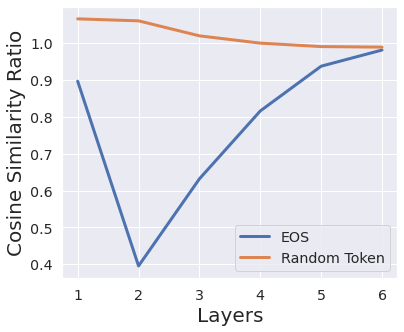

In [1513]:
# wanted_val = 'eos_norms_ratio'
new_df_norm = {'eos_norms_ratio':[],
               'random_token_norms_ratio':[],
               'eos_cosine_ratio':[],
               'random_token_cosine_ratio':[],
               'Layers': []
    
}
for wanted_val in ['eos_norms_ratio','random_token_norms_ratio','eos_cosine_ratio','random_token_cosine_ratio']:
    a = np.array(eos_norms_all_models_results[wanted_val].tolist())
#     for model_norms in eos_norms_all_models_results[wanted_val].tolist():
#         for i, norm in enumerate(model_norms):
#             new_df_norm[wanted_val] = eos_norms_all_models_results[wanted_val]
    print(f"{wanted_val}:")
    print(a.mean(axis=0))
    new_df_norm[wanted_val] = a.mean(axis=0)

# p_1 = sns.lineplot(x = [1,2,3,4,5,6], y = new_df_norm['eos_norms_ratio'], linewidth = 3, label="EOS")
# p_2 = sns.lineplot(x = [1,2,3,4,5,6], y = new_df_norm['random_token_norms_ratio'], linewidth = 3, label="Random Token")
# p_1.set_xlabel("Layers", fontsize = 20)
# p_1.set_ylabel("Norms Ratio", fontsize = 20)
# #plt.show()
# cur_results_dir = '/checkpoint/itayitzhak/emb_raw/results/'
# plt.savefig(cur_results_dir+f"eos_norms_ratio.pdf")


p_1 = sns.lineplot(x = [1,2,3,4,5,6], y = new_df_norm['eos_cosine_ratio'], linewidth = 3, label="EOS")
p_2 = sns.lineplot(x = [1,2,3,4,5,6], y = new_df_norm['random_token_cosine_ratio'], linewidth = 3, label="Random Token")
p_1.set_xlabel("Layers", fontsize = 20)
p_1.set_ylabel("Cosine Similarity Ratio", fontsize = 20)
#plt.show()
cur_results_dir = '/checkpoint/itayitzhak/emb_raw/results/'
plt.savefig(cur_results_dir+f"eos_cosine_ratio.pdf")

### Mid-training checkpoints

In [3509]:
def plot_along_checkpoints(first_values,second_values,all_checkpoints,label_1,label_2,first_y_lim,sec_y_lim):
    fig,ax = plt.subplots()
    ax.plot(all_checkpoints, first_values, alpha=1, color='blue', label=label_1, linewidth=3)
    ax2=ax.twinx()
    ax2.plot(all_checkpoints, second_values, alpha=1, color='red', label=label_2, linewidth=3)
    
    ax.set_ylabel(label_1,color='blue',fontsize=14)
    ax2.set_ylabel(label_2,color='red',fontsize=14)
    ax.set_xlabel('Epoch')
#     for i in range(len(labels)):
#         ax.plot([1,2,3,4,5,6],data_to_plot[labels[i]], alpha=1, color=colors[i], label=labels[i], linewidth=3)
        
#         plt.plot([1,2,3,4,5,6],data_to_plot[labels[0]], alpha=1, color=colors[1], label=labels[1], linewidth=3)
#         plt.plot([1,2,3,4,5,6],data_to_plot['Self'], alpha=1, color=colors[2], label=labels[2], linewidth=3)
    #plt.plot(layer_percentile, alpha=1, label=label, color=color, linewidth=3)
    #plt.hist(self_heads, alpha=0.5, label='Self', histtype='bar')
    #plt.hist(local_heads, alpha=0.5, label='Local', histtype='bar')

    #ax.legend(loc='upper left')
    #ax2.legend(loc='lower right')
    ax2.grid(False)
    #plt.xticks([i for i in range(0,17)])
#     plt.ylabel('Attention Weight')
#     plt.xlabel('Layer')
#     plt.ylim(0,1.0)
#     if label == 'MAD' or label == 'Distance weighted median': # weighted median distance
#        plt.ylim(2,11)
        #plt.ylabel('MAD')
    #if label == "ARD":
        #plt.ylim(0.16,0.28)
        #plt.ylabel('ARD')

    #plt.title(f"{cond} {cond_name} | Train_size={size} | Length={LENGTH}")

    #plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)
    #plt.plot([1/LENGTH]*len(local_heads), label='Uniform Weight')


    #plt.show()
    ax.set_ylim(*first_y_lim)#(0.16,0.38)
    ax2.set_ylim(*sec_y_lim)#(1,8)
    
    if len(all_checkpoints) > 40:
        train_size = 'Medium'
    else:
        train_size = 'Large'
    
    analysis_results_dir = '/checkpoint/itayitzhak/attn_weigths/results/'
    saving_name = analysis_results_dir+f"along_cp_{label_1}_{label_2}_train_size_{train_size}.pdf"
    print(f"Saving Figure in :{saving_name}")
    plt.savefig(saving_name)

In [3510]:
df_res_temp = analysis_all_models_results.copy()
df_res_temp = df_res_temp.rename(
    columns={
        'model_globality_scores': 'ARD',
        'model_distance_weighted_median': 'MAD'
    })
df_res_temp = df_res_temp[(df_res_temp['conj_type']=='s_conj')]
#df_res_temp = df_res_temp[(df_res_temp['seed']=='4')]
df_res_temp['ARD'] = df_res_temp['ARD'].apply(lambda x: x[0])
df_res_temp['MAD'] = df_res_temp['MAD'].apply(lambda x: x[0])
df_res_temp = df_res_temp[['cp','trained_data_type','text_type','conj_type','eval_type', 'trained_data_size','template','ARD','MAD']]

df_res_temp = df_res_temp.replace('ahd_0_1_remove_eos', 'Attention Head Dropout (0.1) Without EOS')
df_res_temp = df_res_temp.replace('ahd_0_3_remove_eos', 'Attention Head Dropout (0.3) Without EOS')
df_res_temp = df_res_temp.replace('remove_eos_not_permuted', 'Trained Without EOS')

res_xd = df_res_temp.groupby(['trained_data_size','text_type','cp', 'trained_data_type']).describe().round(2)
res_xd_ard_mad = res_xd[[('ARD',  'mean'),('ARD',  'std'),('MAD',  'mean'),('MAD',  'std')]]

res_xd_ard_mad

ARD         MAD      
                                                    mean   std  mean   std
trained_data_size text_type cp trained_data_type                          
all               synthetic 1  Trained Without EOS  0.22  0.00  2.19  0.10
                            2  Trained Without EOS  0.24  0.00  2.83  0.09
                            3  Trained Without EOS  0.24  0.00  3.26  0.09
                            4  Trained Without EOS  0.25  0.00  3.56  0.09
                            5  Trained Without EOS  0.25  0.00  3.69  0.11
                            6  Trained Without EOS  0.25  0.00  3.82  0.17
                            7  Trained Without EOS  0.25  0.00  3.90  0.15
                            8  Trained Without EOS  0.25  0.00  3.92  0.15
                            9  Trained Without EOS  0.25  0.00  3.98  0.19
                            10 Trained Without EOS  0.25  0.00  4.05  0.18
                            11 Trained Without EOS  0.25  0.00  4.10  0.20
                            12 Trained Without EOS  0.25  0.00  4.07  0.22
                            13 Trained Without EOS  0.25  0.00  4.07  0.22
                            14 Trained Without EOS  0.25  0.00  4.10  0.18
                            15 Trained Without EOS  0.25  0.01  3.98  0.43
                            16 Trained Without EOS  0.25  0.01  4.05  0.32

In [3511]:
res_xd_ard_mad[('MAD',  'mean')].values,res_xd_ard_mad[('ARD',  'mean')].values

(array([2.19, 2.83, 3.26, 3.56, 3.69, 3.82, 3.9 , 3.92, 3.98, 4.05, 4.1 ,
        4.07, 4.07, 4.1 , 3.98, 4.05]),
 array([0.22, 0.24, 0.24, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
        0.25, 0.25, 0.25, 0.25, 0.25]))

Saving Figure in :/checkpoint/itayitzhak/attn_weigths/results/along_cp_MAD_ARD_train_size_Large.pdf


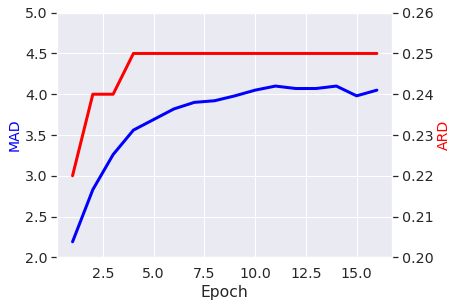

In [3512]:
plot_along_checkpoints(res_xd_ard_mad[('MAD',  'mean')].values,res_xd_ard_mad[('ARD',  'mean')].values,[i for i in range(1,17)],'MAD','ARD',(2,5),(0.20,0.26))

In [3513]:
df_res_temp = analysis_all_models_results.copy()

df_res_temp = df_res_temp[(df_res_temp['eval_type']=='s1_s2')]

#df_res_temp = recompute_consistency(df_res_temp, type_of_compute='None to False')
df_res_temp = recompute_consistency(df_res_temp, type_of_compute='ignore None')


df_res_temp = df_res_temp[['cp','trained_data_type','text_type','conj_type','eval_type', 'trained_data_size','template','first_consistency_score','second_consistency_score','model_bleu']]
#df_res_temp = df_res_temp[['trained_data_type','text_type','conj_type','eval_type', 'trained_data_size','template','first_consistency_score','second_consistency_score','model_bleu']]
df_res_temp['first_consistency_score'] = df_res_temp['first_consistency_score'].apply(lambda x: float(x))
df_res_temp['second_consistency_score'] = df_res_temp['second_consistency_score'].apply(lambda x: float(x))
df_res_temp['model_bleu'] = df_res_temp['model_bleu'].apply(lambda x: float(x[0]))
#res_xd = df_res_temp.groupby(['text_type', 'trained_data_size', 'conj_type', 'eval_type','model_globality_scores','model_distance_weighted_median']).mean().round(3)
df_res_temp = df_res_temp.replace('remove_eos_not_permuted', 'Baseline Without EOS')
df_res_temp = df_res_temp.replace('not_permuted', 'Baseline With EOS')
df_res_temp = df_res_temp.replace('ahd_0_1_remove_eos', 'Attention Head Dropout (0.1) Without EOS')
df_res_temp = df_res_temp.replace('ahd_0_3_remove_eos', 'Attention Head Dropout (0.3) Without EOS')
df_res_temp = df_res_temp.rename(
    columns={
        'first_consistency_score': 'S1p S2',
        'second_consistency_score': 'S3 S2',
        'org_consistency_score': 'Baseline S1 S2',
        'model_bleu': 'BLEU'
    })
df_res_temp = df_res_temp.groupby(['cp','trained_data_type','text_type', 'trained_data_size']).describe().round(2)
#res_xd = df_res_temp.groupby(['text_type', 'trained_data_size','trained_data_type']).describe().round(2)
res_xd_consistency = df_res_temp[[('S1p S2',  'mean'),('S1p S2',  'std'),('S3 S2',  'mean'),('S3 S2',  'std'),('BLEU',  'mean'),('BLEU',  'std')]]
res_xd_consistency

S1p S2       S3 S2        \
                                                      mean   std  mean   std   
cp trained_data_type    text_type trained_data_size                            
1  Baseline Without EOS synthetic all                 0.88  0.02  0.59  0.06   
2  Baseline Without EOS synthetic all                 0.92  0.02  0.81  0.07   
3  Baseline Without EOS synthetic all                 0.93  0.01  0.85  0.03   
4  Baseline Without EOS synthetic all                 0.94  0.01  0.88  0.01   
5  Baseline Without EOS synthetic all                 0.94  0.01  0.89  0.02   
6  Baseline Without EOS synthetic all                 0.93  0.02  0.87  0.03   
7  Baseline Without EOS synthetic all                 0.94  0.01  0.87  0.02   
8  Baseline Without EOS synthetic all                 0.93  0.02  0.88  0.02   
9  Baseline Without EOS synthetic all                 0.93  0.01  0.86  0.03   
10 Baseline Without EOS synthetic all                 0.94  0.01  0.89  0.02   
11 Baseline Without EOS synthetic all                 0.93  0.01  0.88  0.01   
12 Baseline Without EOS synthetic all                 0.93  0.01  0.88  0.02   
13 Baseline Without EOS synthetic all                 0.93  0.01  0.88  0.03   
14 Baseline Without EOS synthetic all                 0.94  0.01  0.89  0.01   
15 Baseline Without EOS synthetic all                 0.93  0.01  0.87  0.01   
16 Baseline Without EOS synthetic all                 0.93  0.01  0.88  0.01   

                                                      BLEU        
                                                      mean   std  
cp trained_data_type    text_type trained_data_size               
1  Baseline Without EOS synthetic all                25.16  0.44  
2  Baseline Without EOS synthetic all                25.16  0.44  
3  Baseline Without EOS synthetic all                25.16  0.44  
4  Baseline Without EOS synthetic all                25.16  0.44  
5  Baseline Without EOS synthetic all                25.16  0.44  
6  Baseline Without EOS synthetic all                25.16  0.44  
7  Baseline Without EOS synthetic all                25.16  0.44  
8  Baseline Without EOS synthetic all                25.16  0.44  
9  Baseline Without EOS synthetic all                25.16  0.44  
10 Baseline Without EOS synthetic all                25.16  0.44  
11 Baseline Without EOS synthetic all                25.16  0.44  
12 Baseline Without EOS synthetic all                25.16  0.44  
13 Baseline Without EOS synthetic all                25.16  0.44  
14 Baseline Without EOS synthetic all                25.16  0.44  
15 Baseline Without EOS synthetic all                25.16  0.44  
16 Baseline Without EOS synthetic all                25.16  0.44

Saving Figure in :/checkpoint/itayitzhak/attn_weigths/results/along_cp_S1p S2_S3 S2_train_size_Large.pdf


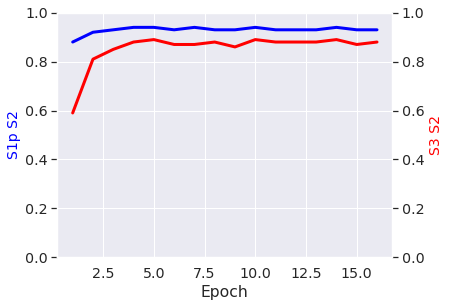

In [3514]:
plot_along_checkpoints(res_xd_consistency[('S1p S2',  'mean')].values,res_xd_consistency[('S3 S2',  'mean')].values,[i for i in range(1,17)],'S1p S2','S3 S2',(0,1.0),(0,1.0))

## Histograms

In [3477]:
def mean_length(df, value_to_mean):
    new_col = []
    for index, row in df.iterrows():
        new_col.append(np.average(row[f'{value_to_mean}'], weights=list(row['lengths_dict'].values()), axis = 0))
    df[f'mean_{value_to_mean}'] = new_col
    
def get_cond_unified_df(df_hist, all_trained_data_type, all_text_types, all_train_sizes, all_conds):
    # all_train_sizes = ['all']
    # all_text_types = ['synthetic']
    # all_conds = zip(["s_conj"], ["s1_s2"])
    all_models = list(itertools.product(all_trained_data_type, all_text_types, all_train_sizes, all_conds))
    new_df = {'trained_data_type':[],
              'text_type':[],
              'trained_data_size':[],
              'conj_type':[],
              'eval_type':[],
              'mean_eos_foucesed_heads':[],
              'mean_local_heads':[],
              'mean_self_heads':[],
              'mean_globality_scores':[],
              'mean_distance_weighted_median':[],
             }
    for trained_data_type, text_type, trained_data_size, conds in all_models:
        #all_heads = []
        all_heads = {
              'mean_eos_foucesed_heads':[],
              'mean_local_heads':[],
              'mean_self_heads':[],
              'mean_globality_scores':[],
              'mean_distance_weighted_median':[],
             }
        new_df['trained_data_type'].append(trained_data_type)
        new_df['text_type'].append(text_type)
        new_df['trained_data_size'].append(trained_data_size)
        new_df['conj_type'].append(conds[0])
        new_df['eval_type'].append(conds[1])

        for index, row in df_hist.iterrows():
            if row['text_type'] == text_type and row['trained_data_size'] == trained_data_size and row['conj_type'] == conds[0] and row['eval_type'] == conds[1]:
                all_heads['mean_eos_foucesed_heads'].extend(row['mean_eos_foucesed_heads'])
                all_heads['mean_local_heads'].extend(row['mean_local_heads'])
                all_heads['mean_self_heads'].extend(row['mean_self_heads'])
                all_heads['mean_globality_scores'].extend(row['mean_globality_scores'])
                all_heads['mean_distance_weighted_median'].extend(row['mean_distance_weighted_median'])
        new_df['mean_eos_foucesed_heads'].append(all_heads['mean_eos_foucesed_heads'])
        new_df['mean_local_heads'].append(all_heads['mean_local_heads'])
        new_df['mean_self_heads'].append(all_heads['mean_self_heads'])
        new_df['mean_globality_scores'].append(all_heads['mean_globality_scores'])
        new_df['mean_distance_weighted_median'].append(all_heads['mean_distance_weighted_median'])
        
    new_df = pd.DataFrame.from_dict(new_df)
    return new_df

def get_table_name(focus):
    if focus == 'EOS': return 'mean_eos_foucesed_heads'
    if focus == 'Local': return 'mean_local_heads'
    if focus == 'Self': return 'mean_self_heads'
    if focus == 'MAD': return 'mean_distance_weighted_median'
    if focus == 'ARD': return 'mean_globality_scores'
    
def filter_one_row(new_df, trained_data_size, text_type, conds, focus_type):
    filter1 = new_df['trained_data_size'] == trained_data_size
    filter2 = new_df['text_type'] == text_type 
    filter3 = new_df['conj_type'] == conds[0] 
    filter4 = new_df['eval_type'] == conds[1] 
    return new_df[filter1 & filter2 & filter3 & filter4].iloc[0]

def add_focus_percentages(df, value_to_mean):
    new_col = []
    for index, row in df.iterrows():
        all_heads = row[f'mean_{value_to_mean}']
        new_col.append()
    df[f'mean_{value_to_mean}'] = new_col

In [3478]:
df_plots = analysis_all_models_results.copy()
for value_to_mean in ['eos_foucesed_heads', 'local_heads', 'self_heads','globality_scores', 'distance_weighted_median', 'percentage_of_EOS', 'percentage_of_local', 'percentage_of_self']:
    mean_length(df_plots, value_to_mean)
    #add_focus_percentages(df_plots, value_to_mean)
#df_hist['model_globality_scores'] = df_hist['model_globality_scores'].apply(lambda x: x[0])
#df_hist['model_distance_weighted_median'] = df_hist['model_distance_weighted_median'].apply(lambda x: x[0])
df_plots = df_plots[['trained_data_type','text_type', 'trained_data_size','conj_type', 'eval_type', 'mean_eos_foucesed_heads','mean_local_heads', 'mean_self_heads','mean_globality_scores','mean_distance_weighted_median', 'mean_percentage_of_EOS', 'mean_percentage_of_local', 'mean_percentage_of_self']]
#res_xd = df_res_temp.groupby(['text_type', 'trained_data_size', 'conj_type', 'eval_type','model_globality_scores','model_distance_weighted_median']).mean().round(3)
#df_hist_gb = df.groupby(['text_type', 'trained_data_size'])#.mean().round(3)
df_plots

# df_plots_focus = get_focus_df(df_plots, get_table_name('ARD'),all_text_types, all_train_sizes, all_conds)

,trained_data_type,text_type,trained_data_size,conj_type,eval_type,mean_eos_foucesed_heads,mean_local_heads,mean_self_heads,mean_globality_scores,mean_distance_weighted_median,mean_percentage_of_EOS,mean_percentage_of_local,mean_percentage_of_self
0,not_permuted,synthetic,tiny,s_conj,s1_s2,[0.0171021030489...,[0.2121232291698...,[0.1079555565729...,[0.3478336910851...,"[7.0586, 5.1704,...",0.0,0.000000,0.000000
1,not_permuted,synthetic,tiny,s_conj,s1_s2,[0.0149779088901...,[0.2209244672417...,[0.1073100090652...,[0.3440465958783...,[7.2585999999999...,0.0,0.000000,0.000000
2,not_permuted,synthetic,tiny,s_conj,s1_s2,[0.0139833199743...,[0.1757756082296...,[0.0984618417993...,[0.3435309860062...,"[7.8488, 7.56260...",0.0,0.000000,0.000000
3,not_permuted,synthetic,tiny,s_conj,s1_s2,[0.0149496933504...,[0.1899584578186...,[0.0941311782047...,[0.3509899109362...,"[8.3732, 6.52380...",0.0,0.000000,0.000000
4,not_permuted,synthetic,tiny,s_conj,s1_s2,[0.0131203177165...,[0.1740090235441...,[0.0904993023753...,[0.3488561030363...,"[8.619, 8.609400...",0.0,0.000000,0.000000
5,not_permuted,synthetic,tiny,s_conj,s1_s2,[0.0152449511988...,[0.2064178736686...,[0.0961127723962...,[0.3493385054806...,"[7.4898, 6.03800...",0.0,0.000000,0.000000
6,not_permuted,synthetic,tiny,s_conj,s1_s2,[0.0136797166602...,[0.1880901400506...,[0.1061236584410...,[0.3419024191704...,"[8.0894, 6.94180...",0.0,0.000000,0.000000
7,not_permuted,synthetic,tiny,s_conj,s1_s2,[0.0141806188609...,[0.1934260018676...,[0.1008384259268...,[0.3458734551809...,"[7.1748, 6.64020...",0.0,0.000000,0.000000
8,not_permuted,synthetic,tiny,s_conj,s1_s2,[0.0138582274839...,[0.2109933453768...,[0.0953536812677...,[0.3456359241307...,"[7.77, 5.9129999...",0.0,0.000000,0.000000
9,not_permuted,synthetic,tiny,s_conj,s1_s2,[0.0144046241130...,[0.1928138107925...,[0.1022395293876...,[0.3421920602963...,"[8.9756, 7.1762,...",0.0,0.000000,0.000000


In [3479]:
#new_df = get_focus_df(df_hist, 'mean_eos_foucesed_heads')
# all_train_sizes = ['all', 'small', 'tiny']
# all_text_types = ['synthetic','semi_natural','natural']
# all_conds = zip(["s_conj","s_conj","s_conj","s_np_vp","s_np_vp","s_np_vp"], ["s1_s2","s1p_s2","s3_s2",'np',"np_prime","vp_prime"])

# print(all_text_types, all_train_sizes, list(all_conds))
# all_models = list(itertools.product(all_text_types, all_train_sizes, all_conds))
# print(f"all_models={all_models}")
# for text_type, trained_data_size, conds in all_models:


#df_plots_focus = get_focus_df(df_plots_focus, 'mean_globality_scores',all_text_types, all_train_sizes, all_conds)

all_trained_data_type = ['Basline_with_EOS_but_not_in_calc']
#all_trained_data_type = ['Basline_with_EOS']
all_train_sizes = ['all', 'small', 'tiny']
all_text_types = ['synthetic','semi_natural','natural']
all_conds = zip(["s_conj","s_conj","s_conj","s_np_vp","s_np_vp","s_np_vp"], ["s1_s2","s1p_s2","s3_s2",'np',"np_prime","vp_prime"])
df_plots_unified = get_cond_unified_df(df_plots, all_trained_data_type, all_text_types, all_train_sizes, all_conds)
df_plots_unified


,trained_data_type,text_type,trained_data_size,conj_type,eval_type,mean_eos_foucesed_heads,mean_local_heads,mean_self_heads,mean_globality_scores,mean_distance_weighted_median
0,Basline_with_EOS...,synthetic,all,s_conj,s1_s2,[0.0262986626656...,[0.1124652734637...,[0.9614010422229...,[0.0941482146483...,[0.1321999999999...
1,Basline_with_EOS...,synthetic,all,s_conj,s1p_s2,[0.0262078637611...,[0.1160288913130...,[0.9638547674179...,[0.0938958751069...,[0.1267999999999...
2,Basline_with_EOS...,synthetic,all,s_conj,s3_s2,[0.0253294855609...,[0.1167159180760...,[0.9613404250502...,[0.0938593347293...,[0.0400000000000...
3,Basline_with_EOS...,synthetic,all,s_np_vp,np,[],[],[],[],[]
4,Basline_with_EOS...,synthetic,all,s_np_vp,np_prime,[],[],[],[],[]
5,Basline_with_EOS...,synthetic,all,s_np_vp,vp_prime,[],[],[],[],[]
6,Basline_with_EOS...,synthetic,small,s_conj,s1_s2,[0.0118784499904...,[0.1923680437892...,[0.0823396325841...,[0.3511173907558...,"[6.7176, 3.5072,..."
7,Basline_with_EOS...,synthetic,small,s_conj,s1p_s2,[0.0115492996361...,[0.1903941962659...,[0.0809542865052...,[0.3507288709530...,[6.7838000000000...
8,Basline_with_EOS...,synthetic,small,s_conj,s3_s2,[0.0121147183891...,[0.2004400156676...,[0.0828876727059...,[0.3520500926810...,"[6.5674, 3.54040..."
9,Basline_with_EOS...,synthetic,small,s_np_vp,np,[],[],[],[],[]


In [3480]:
# Histograms
def plot_hist(model_results, y_type):
    #eos_foucesed_heads, self_heads, local_heads, distance_weighted_median, globality_scores = calc_percentage_of_attn_head_type(avg_attn_matrix)
    if y_type == 'EOS':
        data_to_plot = model_results['mean_eos_foucesed_heads']
        xlim = (0,1.0)
        ylim = (0,800)
        color = "blue"
    if y_type == 'Local':
        data_to_plot = model_results['mean_local_heads']
        color = 'red'
        xlim = (0,1.0)
        ylim = (0,800)
    if y_type == 'Self':
        data_to_plot = model_results['mean_self_heads']
        color = 'green'
        xlim = (0,1.0)
        ylim = (0,800)
    if y_type == 'MAD':
        data_to_plot = model_results['mean_distance_weighted_median']
        color = 'red'
        xlim = (0,20)
        ylim = (0,1000)
        #xlim = (0,0.4)
    if y_type == 'ARD':
        data_to_plot = model_results['mean_globality_scores']
        color = 'blue'
        xlim = (0,0.5)
        ylim = (0,500)
        #xlim = (0,0.1)
        
    plt.hist(data_to_plot, bins=10, alpha=0.8, label=y_type, histtype='bar', color=f'{color}')

    #plt.legend(loc='upper right')
    plt.ylabel('Number of Heads')
    plt.xlabel(f'{y_type}')
    #plt.ylim(0,850)
    #plt.ylim(0,2000)
    plt.ylim(ylim[0],ylim[1])
    plt.xlim(xlim[0],xlim[1])
    
#     if model_results['trained_data_type'] == 'remove_eos_not_permuted':
#         data_type = 'Without EOS'
#     if model_results['trained_data_type'] == 'not_permuted':
#         data_type = 'Original_(with EOS)'
#     if model_results['trained_data_type'] == 'not_permuted_without_eos':
#         data_type = 'Original'
    if model_results['trained_data_size'] == 'tiny':
        data_size = 'Small'
    if model_results['trained_data_size'] == 'small':
        data_size = 'Medium'
    if model_results['trained_data_size'] == 'all':
        data_size = 'Large'
        
    plt.title(f"{data_size}")
    analysis_results_dir = '/checkpoint/itayitzhak/attn_weigths/results/'
    saving_name = analysis_results_dir+f"histogram_{model_results['trained_data_type']}_{y_type}_systematicity_{data_size}_{model_results['text_type']}_{model_results['conj_type']}_{model_results['eval_type']}.pdf"
    print(f"Saving: {saving_name}")
    plt.savefig(saving_name)
    plt.show()
    
def plot_one_hist(df_plots, trained_data_size, text_type, conds, focus_type):
    wanted_row = filter_one_row(df_plots, trained_data_size, text_type, conds, focus_type)
    plot_hist(wanted_row, focus_type)

Saving: /checkpoint/itayitzhak/attn_weigths/results/histogram_Basline_with_EOS_but_not_in_calc_ARD_systematicity_Small_synthetic_s_conj_s1_s2.pdf


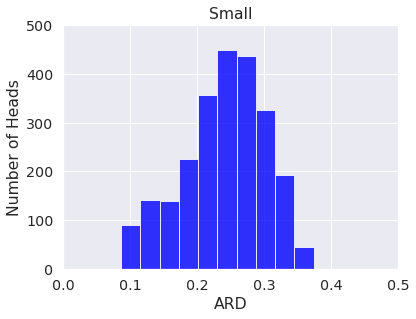

Saving: /checkpoint/itayitzhak/attn_weigths/results/histogram_Basline_with_EOS_but_not_in_calc_ARD_systematicity_Medium_synthetic_s_conj_s1_s2.pdf


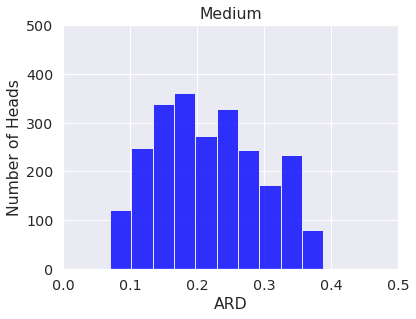

Saving: /checkpoint/itayitzhak/attn_weigths/results/histogram_Basline_with_EOS_but_not_in_calc_ARD_systematicity_Large_synthetic_s_conj_s1_s2.pdf


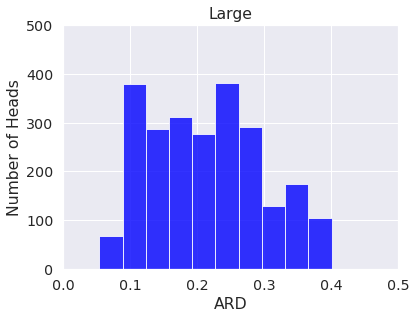

Saving: /checkpoint/itayitzhak/attn_weigths/results/histogram_Basline_with_EOS_but_not_in_calc_MAD_systematicity_Small_synthetic_s_conj_s1_s2.pdf


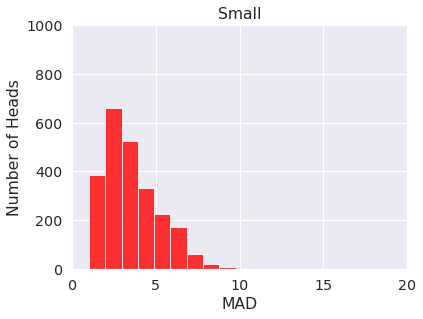

Saving: /checkpoint/itayitzhak/attn_weigths/results/histogram_Basline_with_EOS_but_not_in_calc_MAD_systematicity_Medium_synthetic_s_conj_s1_s2.pdf


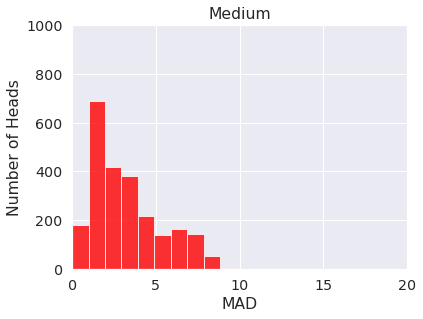

Saving: /checkpoint/itayitzhak/attn_weigths/results/histogram_Basline_with_EOS_but_not_in_calc_MAD_systematicity_Large_synthetic_s_conj_s1_s2.pdf


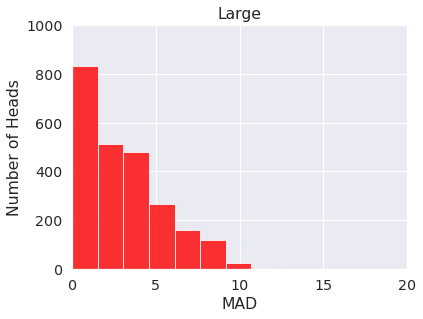

In [3481]:
trained_data_size = 'all'
text_type = 'synthetic'
conds = ("s_conj","s1_s2")
plot_one_hist(df_plots_unified, 'tiny', text_type, conds, "ARD")
plot_one_hist(df_plots_unified, 'small', text_type, conds, "ARD")
plot_one_hist(df_plots_unified, 'all', text_type, conds, "ARD")
plot_one_hist(df_plots_unified, 'tiny', text_type, conds, "MAD")
plot_one_hist(df_plots_unified, 'small', text_type, conds, "MAD")
plot_one_hist(df_plots_unified, 'all', text_type, conds, "MAD")

### Percentage table

In [3482]:
df_percentage = df_plots[['text_type', 'trained_data_size', 'mean_percentage_of_EOS', 'mean_percentage_of_local', 'mean_percentage_of_self']]
#filter_1 = df_percentage['text_type'] == 'natural'
#filter_2 = df_percentage['trained_data_size'] == 'tiny'
#df_percentage = df_percentage[filter_1 & filter_2]
df_percentage
xd_percentage = df_percentage.groupby(['text_type', 'trained_data_size']).mean().round(4)
xd_percentage

mean_percentage_of_EOS  \
text_type    trained_data_size                           
natural      all                                0.0      
             small                              0.0      
             tiny                               0.0      
semi_natural all                                0.0      
             small                              0.0      
             tiny                               0.0      
synthetic    all                                0.0      
             small                              0.0      
             tiny                               0.0      

                                mean_percentage_of_local  \
text_type    trained_data_size                             
natural      all                             0.1165        
             small                           0.0518        
             tiny                            0.0000        
semi_natural all                             0.1034        
             small                           0.0424        
             tiny                            0.0000        
synthetic    all                             0.0888        
             small                           0.0424        
             tiny                            0.0000        

                                mean_percentage_of_self  
text_type    trained_data_size                           
natural      all                             0.1165      
             small                           0.0518      
             tiny                            0.0000      
semi_natural all                             0.1034      
             small                           0.0424      
             tiny                            0.0000      
synthetic    all                             0.0888      
             small                           0.0424      
             tiny                            0.0000

### Across Layers

In [3483]:
import seaborn as sns
def display_ard_mad_focus_across_layers(df_focus, labels, colors=['blue'], num_layers=6, num_heads=8, y_lim_1=(0.16,0.35),y_lim_2=(2,12)):
    data_to_plot = {
      labels[0]:[],
#       labels[1]:[],
#       labels[2]:[],
     }
    for label,color in zip(labels, colors):
        layer_mean = []
        layer_percentile = []
        cur_focus = df_focus[get_table_name(label)]
        #print(len(cur_focus))
        num_of_models = len(cur_focus)
        
        for i in range(0,num_layers*num_heads,num_heads):
            cur_head_attn_accros_models = []
            for j in range(num_of_models):
                #layer_mean.append(sum(cur_focus[i:i+num_heads]) / num_heads)
                start_index = j*num_layers*num_heads + i
                cur_head_attn_accros_models.extend(cur_focus[start_index:start_index+num_heads])
            #layer_percentile.append(np.percentile(cur_head_attn_accros_models, 90))
            #print(len(cur_head_attn_accros_models))
            layer_percentile.append(np.mean(cur_head_attn_accros_models))
        
        data_to_plot[label] = layer_percentile
    
    #print(f"data_to_plot={data_to_plot}")
    #print(f"list(data_to_plot.values())={list(data_to_plot.values())}")

    if label == 'EOS': color = "blue"
    if label == 'Local': color = 'red'
    if label == 'Self': color = 'green'
    if label == 'Distance weighted median': color = 'orange'
    if label == 'Globality Score': color = 'grey'
        
    fig,ax = plt.subplots()
    ax.plot([1,2,3,4,5,6],data_to_plot[labels[0]], alpha=1, color=colors[0], label=labels[0], linewidth=3)
    ax2=ax.twinx()
    ax2.plot([1,2,3,4,5,6],data_to_plot[labels[1]], alpha=1, color=colors[1], label=labels[1], linewidth=3)
    
    ax.set_ylabel("ARD",color='blue',fontsize=14)
    ax2.set_ylabel("MAD",color='red',fontsize=14)
    ax.set_xlabel('Layer')
#     for i in range(len(labels)):
#         ax.plot([1,2,3,4,5,6],data_to_plot[labels[i]], alpha=1, color=colors[i], label=labels[i], linewidth=3)
        
#         plt.plot([1,2,3,4,5,6],data_to_plot[labels[0]], alpha=1, color=colors[1], label=labels[1], linewidth=3)
#         plt.plot([1,2,3,4,5,6],data_to_plot['Self'], alpha=1, color=colors[2], label=labels[2], linewidth=3)
    #plt.plot(layer_percentile, alpha=1, label=label, color=color, linewidth=3)
    #plt.hist(self_heads, alpha=0.5, label='Self', histtype='bar')
    #plt.hist(local_heads, alpha=0.5, label='Local', histtype='bar')

    ax.legend(loc='upper left')
    ax2.legend(loc='lower right')
    ax2.grid(False)
    #plt.xticks([i for i in range(0,17)])
#     plt.ylabel('Attention Weight')
#     plt.xlabel('Layer')
#     plt.ylim(0,1.0)
#     if label == 'MAD' or label == 'Distance weighted median': # weighted median distance
#        plt.ylim(2,11)
        #plt.ylabel('MAD')
    #if label == "ARD":
        #plt.ylim(0.16,0.28)
        #plt.ylabel('ARD')

    #plt.title(f"{cond} {cond_name} | Train_size={size} | Length={LENGTH}")

    #plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)
    #plt.plot([1/LENGTH]*len(local_heads), label='Uniform Weight')


    #plt.show()
    ax.set_ylim(*y_lim_1)
    ax2.set_ylim(*y_lim_2)
    analysis_results_dir = '/checkpoint/itayitzhak/attn_weigths/results/'
#     trained_data_size = 'all'
#     text_type = 'synthetic'
#     conds = ("s_conj","s1_s2")
    trained_date_type = df_focus['trained_data_type']
    saving_name = analysis_results_dir+f"layers_ARD_MAD_systematicity_{trained_date_type}_{trained_data_size}_{text_type}_{conds[0]}_{conds[1]}.pdf"
    print(f"Saving in: {saving_name}")
    plt.savefig(saving_name)


Saving in: /checkpoint/itayitzhak/attn_weigths/results/layers_ARD_MAD_systematicity_Basline_with_EOS_but_not_in_calc_all_synthetic_s_conj_s1_s2.pdf


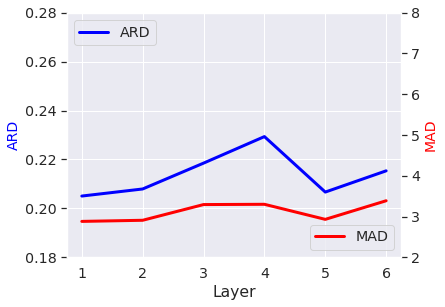

In [3484]:
trained_data_size = 'all'
text_type = 'synthetic'
conds = ("s_conj","s1_s2")
focus_types = ['ARD', 'MAD']
# model_plot_info = {'trained_data_type':trained_data_type,
#                     'trained_data_size':trained_data_size,
#                   'text_type':text_type,
#                    'conds':conds,
#                    'focus_types':focus_types
#                   }

filtered_df = filter_one_row(df_plots_unified, trained_data_size, text_type, conds, focus_type) # (0.16,0.35)
display_ard_mad_focus_across_layers(filtered_df, focus_types, colors=['blue', 'red', 'green'], y_lim_1= (0.18,0.28),y_lim_2=(2,8))


In [3485]:
import seaborn as sns
def display_position_focus_across_layers(df_focus, labels, colors=['blue'], num_layers=6, num_heads=8, y_lim_1=(0.16,0.35),y_lim_2=(2,12)):
    data_to_plot = {
      labels[0]:[],
      labels[1]:[],
      labels[2]:[],
     }
    for label,color in zip(labels, colors):
        layer_mean = []
        layer_percentile = []
        cur_focus = df_focus[get_table_name(label)]
        #print(len(cur_focus))
        num_of_models = len(cur_focus)
        
        for i in range(0,num_layers*num_heads,num_heads):
            cur_head_attn_accros_models = []
            for j in range(num_of_models):
                #layer_mean.append(sum(cur_focus[i:i+num_heads]) / num_heads)
                start_index = j*num_layers*num_heads + i
                cur_head_attn_accros_models.extend(cur_focus[start_index:start_index+num_heads])
            #layer_percentile.append(np.percentile(cur_head_attn_accros_models, 90))
            #print(len(cur_head_attn_accros_models))
            layer_percentile.append(np.mean(cur_head_attn_accros_models))
        
        data_to_plot[label] = layer_percentile


    if label == 'EOS': color = "blue"
    if label == 'Local': color = 'red'
    if label == 'Self': color = 'green'
        
    fig,ax = plt.subplots()
    ax.set_xlabel('Layer')
    for i in range(len(labels)):
        ax.plot([1,2,3,4,5,6],data_to_plot[labels[i]], alpha=1, color=colors[i], label=labels[i], linewidth=3)
    #plt.plot(layer_percentile, alpha=1, label=label, color=color, linewidth=3)


    ax.legend(loc='upper left')
#     ax2.legend(loc='lower right')
#     ax2.grid(False)
    #plt.xticks([i for i in range(0,6)])
    plt.ylabel('Attention Weight')
    plt.xlabel('Layer')
    plt.ylim(0,1.0)
#     if label == 'MAD' or label == 'Distance weighted median': # weighted median distance
#        plt.ylim(2,11)
        #plt.ylabel('MAD')
    #if label == "ARD":
        #plt.ylim(0.16,0.28)
        #plt.ylabel('ARD')

    #plt.title(f"{cond} {cond_name} | Train_size={size} | Length={LENGTH}")



    plt.show()
#     ax.set_ylim(*y_lim_1)
#     ax2.set_ylim(*y_lim_2)
    analysis_results_dir = '/checkpoint/itayitzhak/attn_weigths/results/'
#     trained_data_size = 'all'
#     text_type = 'synthetic'
#     conds = ("s_conj","s1_s2")
    saving_name = analysis_results_dir+f"layers_ARD_MAD_systematicity_{df_focus['trained_data_type']}_{trained_data_size}_{text_type}_{conds[0]}_{conds[1]}.pdf"
    print(f"Saving in: {saving_name}")
    plt.savefig(saving_name)


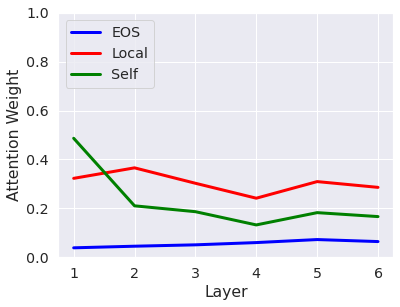

Saving in: /checkpoint/itayitzhak/attn_weigths/results/layers_ARD_MAD_systematicity_Basline_with_EOS_but_not_in_calc_all_synthetic_s_conj_s1_s2.pdf


<Figure size 432x324 with 0 Axes>

In [3486]:
trained_data_size = 'all'
text_type = 'synthetic'
conds = ("s_conj","s1_s2")
focus_types = ['EOS', 'Local', 'Self']

filtered_df = filter_one_row(df_plots_unified, trained_data_size, text_type, conds, focus_type)
display_position_focus_across_layers(filtered_df, focus_types, colors=['blue', 'red', 'green'], y_lim_1=(0.16,0.35),y_lim_2=(2,12))

In [892]:
# print(df_hist_gb)

# def compress_group(group):
#     print(group)
#     for scores in group:
#         np.average(data_to_plot, weights=list(model_results['lengths_dict'].values()), axis = 0)
        
#df_hist_gb.apply(lambda group: [compress_group(x) for x in group]) 

In [ ]:
for cur_model_path, results in analysis_all_models_results.items():
    print(cur_model_path)
    print(results['eos_foucesed_heads'][0][:10])
    plot_hist(cur_model_path, results, "EOS")
    plot_hist(cur_model_path, results, "Local")
    plot_hist(cur_model_path, results, "Self")
    plot_hist(cur_model_path, results, "Distance weighted median")
    plot_hist(cur_model_path, results, "Globality Score")
    print("="*100)

In [3498]:
# for train_size in ['all', 'small', 'tiny']:
#     bleus = []
#     print(train_size)
#     for seed in [1,2,3,4,5]:
#         bleus.append(get_bleu_score(f'remove_eos_not_permuted_seed_{seed}', train_size))
#     print(f"bleus={bleus}")
#     print(f"{train_size} bleu mean is={np.mean(bleus).round(2)} -+{np.std(bleus).round(2)}")

### Examples print out

getting samples dict from: /checkpoint/itayitzhak/attn_weigths/remove_eos_not_permuted_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_tiny/generate-test.txt
The athletes carefully avoid the mayor , and the boy recognises the general . EOS
LAYER=3, HEAD=0
Global Metric = 0.20
Weighted Median = 2.70


(0.20221264376970274, 2.700000000000001)

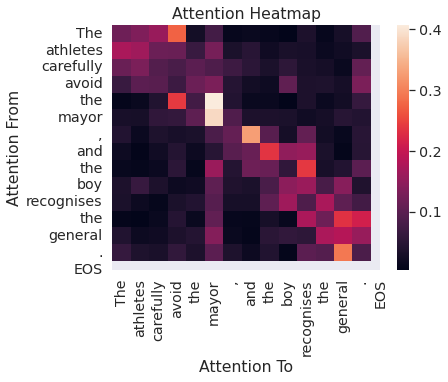

In [2857]:
#model_attn_dir = '/checkpoint/itayitzhak/attn_weigths/not_permuted_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all'
#model_attn_dir = '/checkpoint/itayitzhak/attn_weigths/adspan_after_sm_cone_remove_eos_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_tiny'
model_attn_dir = '/checkpoint/itayitzhak/attn_weigths/remove_eos_not_permuted_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_tiny'
layer = 3
head = 0
sample_num = 2
NUM_LAYERS = 6
NUM_HEADS = 8
MAX_POSITION = 30
all_samples = get_all_samples_dict(model_attn_dir+'/generate-test.txt')

# for layer in [0,1,2,3,4,5]:
#     for head in [0,1,2,3,4,5,6,7]:
#         display_sample(layer, head, sample_num, all_samples, model_attn_dir, print_out=True)
display_sample(layer, head, sample_num, all_samples, model_attn_dir, print_out=True)

getting samples dict from: /checkpoint/itayitzhak/attn_weigths/not_permuted_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all/generate-test.txt
The aunt carefully recognises the director , and the women recognise the queen . EOS
LAYER=5, HEAD=2
Global Metric = 0.39
Weighted Median = 12.60


(0.38650622236618803, 12.6)

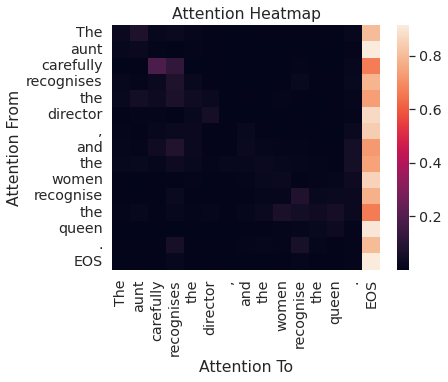

In [1674]:
# example_global
layer = 5
head = 2
sample_num = 3
NUM_LAYERS = 6
NUM_HEADS = 8
MAX_POSITION = 30
all_samples = get_all_samples_dict(model_attn_dir+'/generate-test.txt')
display_sample(layer, head, sample_num, all_samples, model_attn_dir, print_out=True)

# OLD code

In [3515]:
sns.set_context("talk")
results = pickle.load(open("/checkpoint/itayitzhak/all_models_final_results_templates.pt", 'rb'))
results = all_models_final_results
all_seeds = range(4,6)
all_templates = list(range(1,11))
all_trained_data_type = ["not_permuted", 'remove_eos_not_permuted']
all_text_types = ["synthetic"]
all_data_sizes = ["tiny", "small", "all"]

with_bleu = True
with_samples_globalities = True

s1p_results = []
s3_results = []
bleu_results = []
models = [] 
hue = []
s1p_all_annotations = []
s3_all_annotations = []
bleu_all_annotations = []

#for text_type in ["synthetic", "semi_natural", "natural"]:
for text_type in all_text_types:
    for trained_data_type in all_trained_data_type:
        for data_size in all_data_sizes:
            s1p_annotations = []
            s3_annotations = []
            bleu_annotations = []
            #for t in range(1, 11):
            for i_seed, seed in enumerate(all_seeds):
    #             size_results = [results[(f"transformer_{model}_{seed}", seed, "s_conj", data_type, t)]
    #                             for seed in [1, 2, 3, 4, 5]]
#                 s1p = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist']
#                 s3 = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist']
#                 bleu = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu']
#                 if trained_data_type == "not_permuted" and data_size != 'all' and seed == 3:
#                         continue
                print(f"seed={seed}")
                print([results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist'][i_seed]
                      for t in all_templates])
                s1p = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist'][i_seed]
                      for t in all_templates
                      ]
                s3 = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist'][i_seed]
                      for t in all_templates
                      ]
                if with_bleu:
                    bleu = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu'][i_seed]
                          for t in all_templates
                          ]
#                 s3 = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist'][seed-1]
#                 bleu = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu'][seed-1]
        
                #s1p, s3 = zip(*size_results)
                # print(f"s1p:{s1p}")
                # print(f"s3:{s3}")
                # print(f"{data_size}_{trained_data_type}_bleu:{bleu}")
                s1p_results.append(np.mean(s1p))
                s3_results.append(np.mean(s3))
                if with_bleu:
                    bleu_results.append(np.mean(bleu))
                #print(f"trained_data_type, text_type, t, np.mean(s3)={trained_data_type, text_type, t, np.mean(s3)}")
                #models.append(trained_data_type)
                #hue.append(text_type)
                models.append(data_size)
                hue.append(trained_data_type)
#                 s1p_annotations.append((np.mean(s1p), trained_data_type, data_size, t))
#                 s3_annotations.append((np.mean(s3), trained_data_type, data_size, t))
#                 bleu_annotations.append((np.mean(bleu), trained_data_type, data_size, t))
                s1p_annotations.append((np.mean(s1p), trained_data_type, data_size, seed))
                s3_annotations.append((np.mean(s3), trained_data_type, data_size, seed))
                if with_bleu:    
                    bleu_annotations.append((np.mean(bleu), trained_data_type, data_size, seed))
            s3_all_annotations.append(min(s3_annotations))
            s3_all_annotations.append(max(s3_annotations))
            s1p_all_annotations.append(min(s1p_annotations))
            s1p_all_annotations.append(max(s1p_annotations))
            if with_bleu:
                bleu_all_annotations.append(min(bleu_annotations))
                bleu_all_annotations.append(max(bleu_annotations))

seed=4


KeyError: "not_permuted_tiny_synthetic_('s_conj', 's1_s2')_1_compositional_mt__"

In [3516]:
plt.figure(figsize=(6, 6))
sns.stripplot(x=hue, y=s1p_results, hue=models, dodge=True, zorder=1, label=None, alpha=0.3, size=8, palette="viridis")
ax = sns.pointplot(x=hue, y=s1p_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
plt.legend([], [], frameon=False)
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["Org", "No-EOS"])
ax.set_ylabel("consistency (S1P)")
plt.ylim(0.6, 1)
for y, x, m, t in s1p_all_annotations:
    if x == "natural":
        continue
    #x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"not_permuted": 0, "remove_eos_not_permuted": 1}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.1
    if m == "all":
        x += 0.1
    plt.text(x, y, t, fontsize=15)
#plt.savefig("/checkpoint/itayitzhak/figures/s1p.pdf", bbox_inches="tight")
plt.show()


plt.figure(figsize=(6, 6))
ax = sns.pointplot(x=hue, y=s3_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
sns.stripplot(x=hue, y=s3_results, hue=models, dodge=True, zorder=-1, label=None, alpha=0.3, size=8, palette="viridis")
plt.legend([], [], frameon=False) #["tiny", "small", "all"], bbox_to_anchor=(0.57, 1.05))
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["Org", "No-EOS"])
ax.set_ylabel("consistency S3_S2")
plt.ylim(0.2, 1)
for y, x, m, t in s3_all_annotations:
    if x == "natural":
        continue
    #x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"not_permuted": 0, "remove_eos_not_permuted": 1}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.05
    if m == "all":
        x += 0.2
    plt.text(x, y, t, fontsize=15)
#ax.set_yticks([])
#plt.savefig("/checkpoint/itayitzhak/figures/s3.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(6, 6))
ax = sns.pointplot(x=hue, y=bleu_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
sns.stripplot(x=hue, y=s3_results, hue=models, dodge=True, zorder=-1, label=None, alpha=0.3, size=8, palette="viridis")
plt.legend([], [], frameon=False) #["tiny", "small", "all"], bbox_to_anchor=(0.57, 1.05))
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["Org", "No-EOS"])
ax.set_ylabel("BLEU")
plt.ylim(20, 26)
for y, x, m, t in bleu_all_annotations:
    if x == "natural":
        continue
    #x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"not_permuted": 0, "remove_eos_not_permuted": 1}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.05
    if m == "all":
        x += 0.2
    plt.text(x, y, t, fontsize=15)
#ax.set_yticks([])
#plt.savefig("/checkpoint/itayitzhak/figures/s3.pdf", bbox_inches="tight")
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 432x432 with 0 Axes>

### Bar Plots

In [97]:
def get_bar_plot(models_final_results, wanted_keys, wanted_y, ylim, wanted_conds=('s_conj','s1_s2'),templates_to_use=[i for i in range(1,11)]):
    data_to_plot = create_df_from_results(models_final_results, wanted_keys, wanted_y, wanted_conds, templates_to_use)
    sns.set_context('paper')
    sns.set(rc={'figure.figsize':(8,4)})
    plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
    plt.tight_layout()
    sns.set(font_scale=0.8)
    plt.ylim(ylim[0], ylim[1])
    
#     ax = sns.barplot(x = 'Data Size', y = wanted_y, data = data_to_plot,
#             palette = 'hls', hue = 'Training Data Type',
#             #order = ['trained_data_size'],#['tiny', 'small', 'all'],  
#             capsize = 0.05,             
#             saturation = 12,             
#             errcolor = 'gray', errwidth = 2,  
#             ci = 'sd'   
#             )
    ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
    plt.show()

### Verna's Plots

key=Training Data Type
********************
key=Data Size
********************
key=Distance Weighted Median Distrubation
********************


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (9).

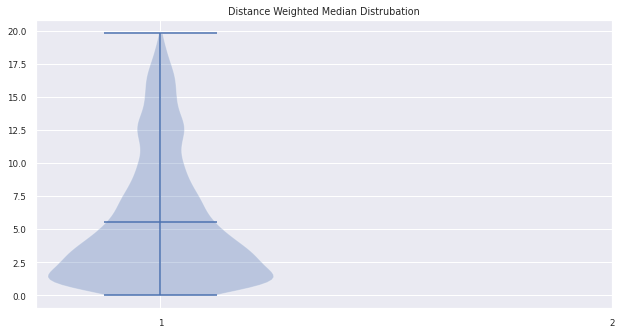

In [190]:
def show_violin_new(models_final_results, wanted_keys, wanted_y, wanted_conds=('s_conj','s1_s2')):
    data_to_plot = create_df_from_results(models_final_results, wanted_keys, wanted_y, wanted_conds)
    labels = (data_to_plot['Training Data Type'] + data_to_plot['Data Size']).unique()
    dists = list(data_to_plot[wanted_y])
    fig = plt.figure()
    ax1 = fig.add_axes([0,0,1,1])
    #print(f"dists:{dists}")
    bp_eos = ax1.violinplot(dists, showmeans=True)
    ax1.set_title(wanted_y)
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(labels, rotation=0)

    plt.show()

show_violin_new(
    all_models_final_results,
    ['trained_data_type','trained_data_size','distance_weighted_median'],
    'Distance Weighted Median Distrubation', wanted_conds=('s_conj','s1_s2'))

In [ ]:
def show_violin(dists, title, labels):
    # df_all_eos_foucesed_heads = pd.DataFrame(all_eos_foucesed_heads).transpose()
    # ax = sns.violinplot(x=["a", "b"],data=df_all_eos_foucesed_heads)

    # Create a figure instance
    fig = plt.figure()

    #fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,6), sharex=False)

    # Create an axes instance
    ax1 = fig.add_axes([0,0,1,1])
    # ax2 = fig.add_axes([0,0,1,1])
    # ax3 = fig.add_axes([0,0,1,1])

    # Create the boxplot
    #ax1.xlabels(["a","b","c","a","b","c"])
    bp_eos = ax1.violinplot(dists, showmeans=True)

    # plt.show()
    # bp = ax.violinplot(all_distance_weighted_median)
    # plt.show()
    # bp = ax.violinplot(all_globality_scores)
    ax1.set_title(title)

    #ax1.set_xticklabels(["0","Not Permuted (Small)","5-gram Permuted (Small)","Permuted (Small)","Not Permuted (All)","5-gram Permuted (All)","Permuted (All)"], rotation=90)
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(labels, rotation=0)

    plt.show()

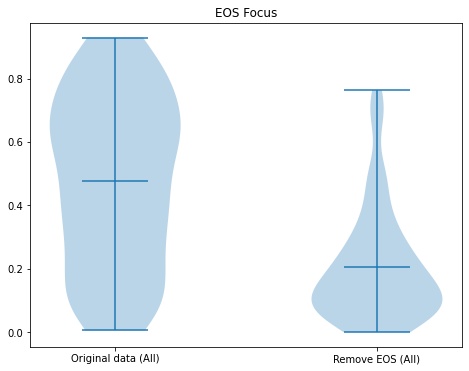

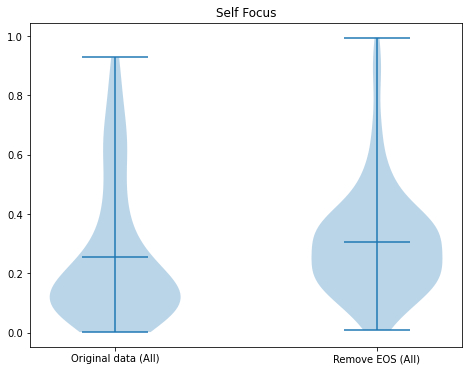

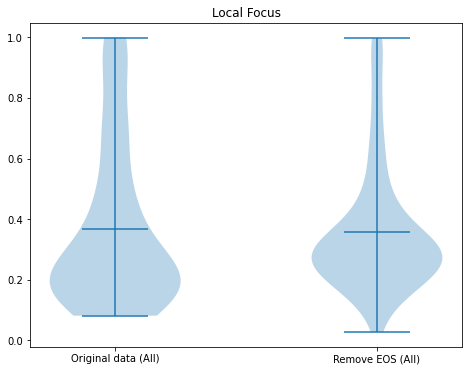

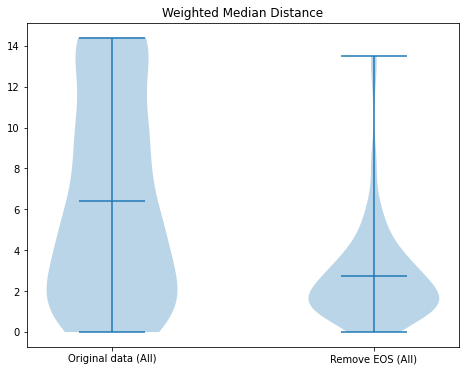

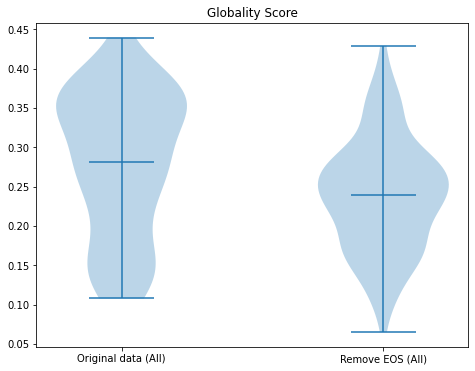

In [480]:
show_violin(all_eos_foucesed_heads, 'EOS Focus', ["Original data (All)","Remove EOS (All)"])
show_violin(all_self_heads, 'Self Focus', ["Original data (All)","Remove EOS (All)"])
show_violin(all_local_heads, 'Local Focus', ["Original data (All)","Remove EOS (All)"])
show_violin(all_distance_weighted_median, 'Weighted Median Distance', ["Original data (All)","Remove EOS (All)"])
show_violin(all_globality_scores, 'Globality Score', ["Original data (All)","Remove EOS (All)"])

In [1358]:
def print_single_ttest(H_0,H_1,name_1,name_2):
    print(f"T-test for {name_1} vs {name_2}",end=':')
    print(f"p-value <= {stats.ttest_ind(H_0, H_1)[1]:.4f}")
    
def calc_ttest(data_for_ttest):
#     print("T-test for Not Permuted vs 5-gram Permuted (Small)",end=':')
#     print(f"p-value <= {stats.ttest_ind(data_for_ttest[0], data_for_ttest[1])[1]:.2f}")
    print_single_ttest(data_for_ttest[0],data_for_ttest[1],"Not Permuted","5-gram Permuted (Small)")
    print("T-test for Not Permuted vs Permuted (Small)",end=':')
    print(f"p-value <= {stats.ttest_ind(data_for_ttest[0], data_for_ttest[2])[1]:.2f}")
    print("T-test for Not Permuted vs 5-gram Permuted (All)",end=':')
    print(f"p-value <= {stats.ttest_ind(data_for_ttest[3], data_for_ttest[4])[1]:.2f}")
    print("T-test for Not Permuted vs Permuted (All)",end=':')
    #print(stats.ttest_ind(all_distance_weighted_median[3], all_distance_weighted_median[5]))
    print(f"p-value <= {stats.ttest_ind(data_for_ttest[3], data_for_ttest[5])[1]:.2f}")
# calc_ttest(all_distance_weighted_median)


In [486]:
print_single_ttest(all_eos_foucesed_heads[0],all_eos_foucesed_heads[1],"EOS Original data (All)","EOS Remove EOS (All)")
print_single_ttest(all_self_heads[0],all_self_heads[1],"SELF Original data (All)"," SELF Remove EOS (All)")
print_single_ttest(all_local_heads[0],all_local_heads[1],"LOCAL Original data (All)","Local Remove EOS (All)")
print_single_ttest(all_distance_weighted_median[0],all_distance_weighted_median[1],"Weighted Distance Original data (All)","Weighted Distance Remove EOS (All)")
print_single_ttest(all_globality_scores[0],all_globality_scores[1],"Globality Original data (All)","Gloablity Remove EOS (All)")

T-test for EOS Original data (All) vs EOS Remove EOS (All):p-value <= 0.0000
T-test for SELF Original data (All) vs  SELF Remove EOS (All):p-value <= 0.0398
T-test for LOCAL Original data (All) vs Local Remove EOS (All):p-value <= 0.6598
T-test for Weighted Distance Original data (All) vs Weighted Distance Remove EOS (All):p-value <= 0.0000
T-test for Globality Original data (All) vs Gloablity Remove EOS (All):p-value <= 0.0000


<ipython-input-382-d8c9eed61aa8>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["0","Not Permuted (Small)","5-gram Permuted (Small)","Permuted (Small)","Not Permuted (All)","5-gram Permuted (All)","Permuted (All)"], rotation=90)


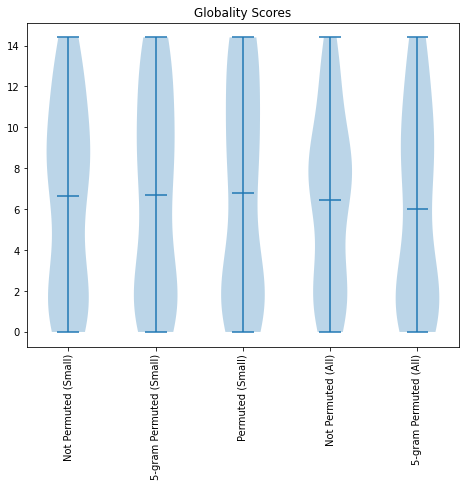

In [382]:
# df_all_eos_foucesed_heads = pd.DataFrame(all_eos_foucesed_heads).transpose()
# ax = sns.violinplot(x=["a", "b"],data=df_all_eos_foucesed_heads)

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax1 = fig.add_axes([0,0,1,1])

# Create the boxplot
bp_eos = ax1.violinplot(all_seeds_distance_weighted_median, showmeans=True)

ax1.set_title('Globality Scores')
ax1.set_xticklabels(["0","Not Permuted (Small)","5-gram Permuted (Small)","Permuted (Small)","Not Permuted (All)","5-gram Permuted (All)","Permuted (All)"], rotation=90)

plt.show()

### Consistency Vs. Globality

In [18]:
sns.set_context("talk")
#results = pickle.load(open("/checkpoint/itayitzhak/all_models_final_results_templates.pt", 'rb'))
results = temp_all_models_final_results
all_seeds = range(4,5)
all_templates = list(range(1,2))
all_trained_data_type = ['remove_eos_not_permuted']#["not_permuted"]#["not_permuted", 'remove_eos_not_permuted']
all_text_types = ["synthetic"]
all_data_sizes = ["all"]#["tiny", "small", "all"]

with_samples_globalities = True

s1p_results = []
s3_results = []
bleu_results = []
models = [] 
hue = []
s1p_all_annotations = []
s3_all_annotations = []
bleu_all_annotations = []

#for text_type in ["synthetic", "semi_natural", "natural"]:
for text_type in all_text_types:
    for trained_data_type in all_trained_data_type:
        for data_size in all_data_sizes:
            s1p_annotations = []
            s3_annotations = []
            bleu_annotations = []
            #for t in range(1, 11):
            for i_seed, seed in enumerate(all_seeds):
    #             size_results = [results[(f"transformer_{model}_{seed}", seed, "s_conj", data_type, t)]
    #                             for seed in [1, 2, 3, 4, 5]]
#                 s1p = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist']
#                 s3 = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist']
#                 bleu = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu']
#                 if trained_data_type == "not_permuted" and data_size != 'all' and seed == 3:
#                         continue
                print(f"seed={seed}")
                print([results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['all_sampels_s_conj_s1p_s2_consist'][i_seed]
                      for t in all_templates])
                samples_s1p = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['all_sampels_s_conj_s1p_s2_consist'][i_seed]
                      for t in all_templates
                      ]
                samples_s3 = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['all_sampels_s_conj_s3_s2_consist'][i_seed]
                      for t in all_templates
                      ]
                samples_globalities = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['all_sampels_gloablity'][i_seed]
                  for t in all_templates
                  ]
                samples_weighted_median_distance = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['all_sampels_weighted_median_distance'][i_seed]
                  for t in all_templates
                  ]
#                 s3 = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist'][seed-1]
#                 bleu = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu'][seed-1]
        
                #s1p, s3 = zip(*size_results)
                # print(f"s1p:{s1p}")
                # print(f"s3:{s3}")
                # print(f"{data_size}_{trained_data_type}_bleu:{bleu}")
#                 s1p_consist_glob_results.append(samples_globalities[samples_s1p])
#                 s3_consist_glob_results.append(samples_globalities[samples_s3])
#                 s1p_not_consist_glob_results.append(samples_globalities[[ not x for x in samples_s1p]])
#                 s3_not_consist_glob_results.append(samples_globalities[[ not x for x in samples_s3]])
                
#                 s1p_consist_wmd_results.append(samples_globalities[samples_s1p])
#                 s3_consist_wmd_results.append(samples_globalities[samples_s3])
#                 s1p_not_consist_wmd_results.append(samples_globalities[[not x for x in samples_s1p]])
#                 s3_not_consist_wmd_results.append(samples_globalities[[not x for x in samples_s3]])
                #print(f"trained_data_type, text_type, t, np.mean(s3)={trained_data_type, text_type, t, np.mean(s3)}")
                #models.append(trained_data_type)
                #hue.append(text_type)
                models.append(data_size)
                hue.append(trained_data_type)
#                 s1p_annotations.append((np.mean(s1p), trained_data_type, data_size, t))
#                 s3_annotations.append((np.mean(s3), trained_data_type, data_size, t))
#                 bleu_annotations.append((np.mean(bleu), trained_data_type, data_size, t))
            #     s1p_annotations.append((np.mean(s1p), trained_data_type, data_size, seed))
            #     s3_annotations.append((np.mean(s3), trained_data_type, data_size, seed))
            #     if with_bleu:    
            #         bleu_annotations.append((np.mean(bleu), trained_data_type, data_size, seed))
            # s3_all_annotations.append(min(s3_annotations))
            # s3_all_annotations.append(max(s3_annotations))
            # s1p_all_annotations.append(min(s1p_annotations))
            # s1p_all_annotations.append(max(s1p_annotations))
            # if with_bleu:
            #     bleu_all_annotations.append(min(bleu_annotations))
            #     bleu_all_annotations.append(max(bleu_annotations))

seed=4
[[True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, 

In [ ]:
def plot_globalality_to_consistenecy(models_final_results, wanted_keys, wanted_conds=('s_conj','s1_s2'),templates_to_use=[1]):
    data_to_plot = create_df_from_results(models_final_results, wanted_keys, False, wanted_conds, templates_to_use, explode_wanted_y=False)
    print(f"data_to_plot={data_to_plot}")
    sns.set_context('paper')
    sns.set(rc={'figure.figsize':(6,4)})
    plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
    plt.tight_layout()
    sns.set(font_scale=0.8)
    plt.ylim(0.26,0.32)
    #ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection = '3d')
    #ax.scatter(x = data_to_plot["samples_s1p"], y = data_to_plot["samples_globalities"], z = data_to_plot["samples_s3"], s=80)
    #ax = sns.scatterplot(x = wanted_keys[0], y = wanted_keys[1], data = data_to_plot, s=80)
    ax = plt.scatter(x = data_to_plot[wanted_keys[0]], y = data_to_plot[wanted_keys[1]])
    ax.set_xticks(range(0,2))
    ax.set_xticklabels(['Not Consistent','Consistent'])
    plt.show()
    
plot_globalality_to_consistenecy(temp_all_models_final_results, ["all_sampels_s_conj_s1p_s2_consist", "all_sampels_gloablity", "all_sampels_weighted_median_distance"], wanted_conds=('s_conj','s1_s2'),templates_to_use=[1])

In [38]:
data_to_plot = {
                "samples_s1p": samples_s1p[0],
                "samples_s3": samples_s3[0],
                #"s1p_not_consist_glob_results": s1p_not_consist_glob_results,
                "samples_globalities": samples_globalities[0],
                "samples_weighted_median_distance": samples_weighted_median_distance[0],
                # s3_consist_glob_results.append(samples_globalities[samples_s3])
                # s1p_not_consist_glob_results.append(samples_globalities[[ not x for x in samples_s1p]])
                # s3_not_consist_glob_results.append(samples_globalities[[ not x for x in samples_s3]])
                
                # s1p_consist_wmd_results.append(samples_globalities[samples_s1p])
                # s3_consist_wmd_results.append(samples_globalities[samples_s3])
                # s1p_not_consist_wmd_results.append(samples_globalities[[not x for x in samples_s1p]])
                # s3_not_consist_wmd_results.append(samples_globalities[[not x for x in samples_s3]])
}
data_to_plot = pd.DataFrame(data_to_plot)

In [39]:
data_to_plot

,samples_s1p,samples_s3,samples_globalities,samples_weighted_median_distance
0,True,True,0.205507,4.127083
1,True,True,0.203475,4.485417
2,True,True,0.204095,4.212500
3,True,True,0.202143,4.289583
4,True,False,0.202455,4.250000
...,...,...,...,...
495,True,True,0.187731,5.270833
496,True,True,0.186346,5.145833
497,True,True,0.182647,5.062500
498,True,True,0.183231,5.395833


In [41]:
# Logsitic regression
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

np_samples_globalities = np.array(samples_globalities)
np_samples_s1p = np.array(samples_s1p)
print(f"np_samples_globalities.shape={np_samples_globalities.shape}")
print(f"baseline:{(np_samples_s1p.sum())/500}")
w = {0:(500-np_samples_s1p.sum())/500,1:np_samples_s1p.sum()/500}
print(w)
X_train, X_test, y_train, y_test = train_test_split(
    np_samples_globalities[0], np_samples_s1p[0], test_size=0.10, random_state=0)
LRG = linear_model.LogisticRegression(
   random_state = 0,solver = 'liblinear',multi_class = 'auto', class_weight=w)


LRG.fit(X_train.reshape(-1, 1), y_train)
LRG.score(X_test.reshape(-1, 1), y_test)

np_samples_globalities.shape=(1, 500)
baseline:0.938
{0: 0.062, 1: 0.938}


0.94

No handles with labels found to put in legend.


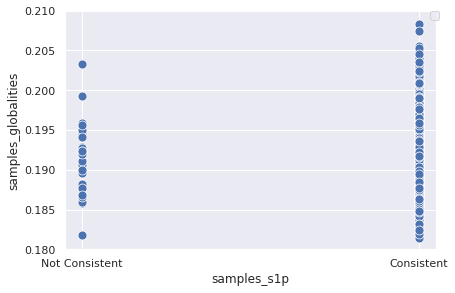

In [46]:
sns.set_context('paper')
sns.set(rc={'figure.figsize':(6,4)})
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.tight_layout()
sns.set(font_scale=0.8)
plt.ylim(0.18,0.21)
#ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection = '3d')
#ax.scatter(x = data_to_plot["samples_s1p"], y = data_to_plot["samples_globalities"], z = data_to_plot["samples_s3"], s=80)
ax = sns.scatterplot(x = "samples_s1p", y = "samples_globalities", data = data_to_plot, s=80)
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Not Consistent','Consistent'])
plt.show()

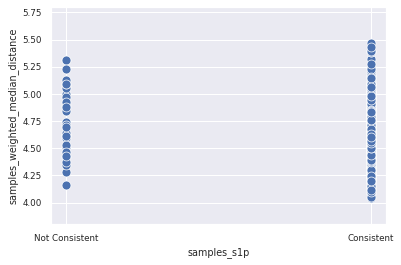

In [47]:
plt.ylim(3.8,5.8)
#ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
ax = sns.scatterplot(x = "samples_s1p", y = "samples_weighted_median_distance", data = data_to_plot, s=80)
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Not Consistent','Consistent'])
plt.show()

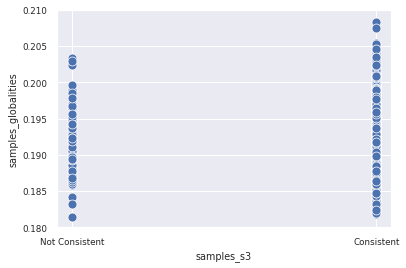

In [48]:
plt.ylim(0.18,0.21)
#ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
ax = sns.scatterplot(x = "samples_s3", y = "samples_globalities", data = data_to_plot, s=80)
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Not Consistent','Consistent'])
plt.show()

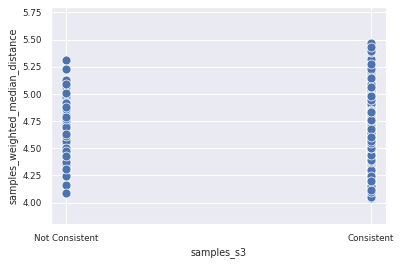

In [49]:
plt.ylim(3.8,5.8)
#ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
ax = sns.scatterplot(x = "samples_s3", y = "samples_weighted_median_distance", data = data_to_plot, s=80)
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Not Consistent','Consistent'])
plt.show()

In [63]:
show_violin(data_to_plot, "samples_weighted_median_distance", ["samples_s3"])

NameError: name 'show_violin' is not defined

### Layer Plots

In [184]:
def display_focus_across_layers(cur_focus, label, color='blue'):
    layer_mean = []
    layer_percentile = []
    for i in range(0,NUM_LAYERS*NUM_HEADS,NUM_HEADS):
        layer_mean.append(sum(cur_focus[i:i+NUM_HEADS]) / NUM_HEADS)
        layer_percentile.append(np.percentile(cur_focus[i:i+NUM_HEADS], 90))

    if label == 'EOS': color = "blue"
    if label == 'Local': color = 'red'
    if label == 'Self': color = 'green'
    if label == 'Distance weighted median': color = 'orange'
    if label == 'Globality Score': color = 'grey'

    plt.plot(layer_percentile, alpha=1, label=label, color=color, linewidth=3)
    #plt.hist(self_heads, alpha=0.5, label='Self', histtype='bar')
    #plt.hist(local_heads, alpha=0.5, label='Local', histtype='bar')

    plt.legend(loc='lower right')
    #plt.xticks([i for i in range(0,17)])
    plt.ylabel('Attention Weight')
    plt.xlabel('Layer')
    plt.ylim(0,1.0)
    if label == 'Median Distance' or label == 'Distance weighted median': # weighted median distance
        plt.ylim(0,17)
    if label == "Globality Score":
        plt.ylim(0.3,0.5)
        
    #plt.title(f"{cond} {cond_name} | Train_size={size} | Length={LENGTH}")

    #plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)
    #plt.plot([1/LENGTH]*len(local_heads), label='Uniform Weight')


    plt.show()

    print(f"Model:{cur_model_path}")
display_focus_across_layers(eos_foucesed_heads, label='EOS-focus')

NameError: name 'eos_foucesed_heads' is not defined

not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


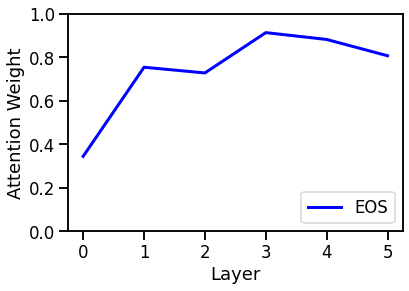

Model:not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


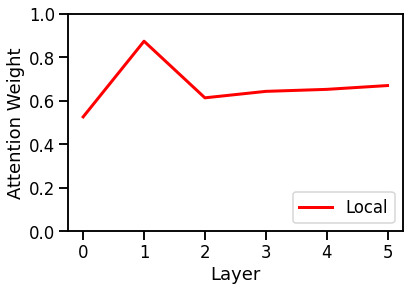

Model:not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


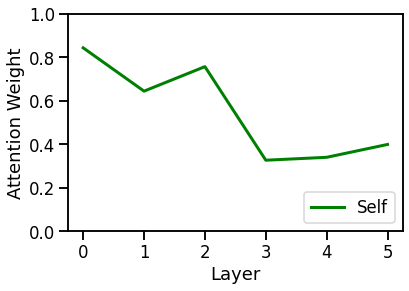

Model:not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


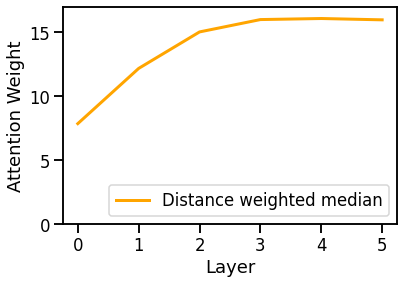

Model:not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


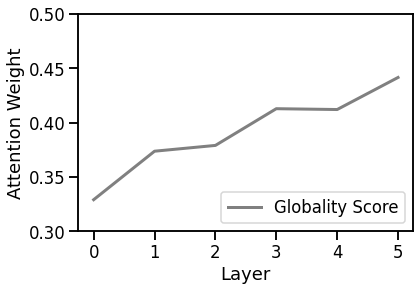

Model:not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__
remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


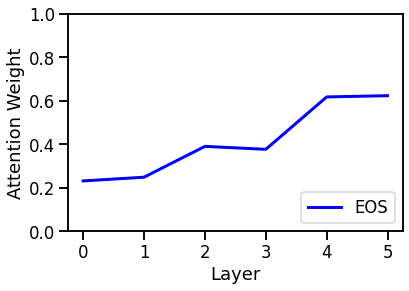

Model:remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


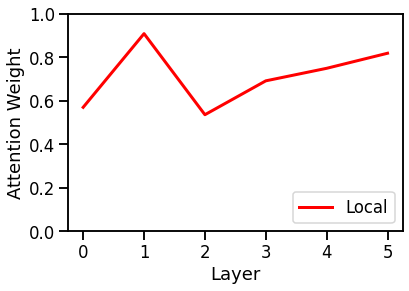

Model:remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


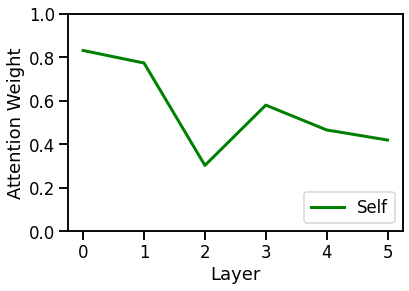

Model:remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


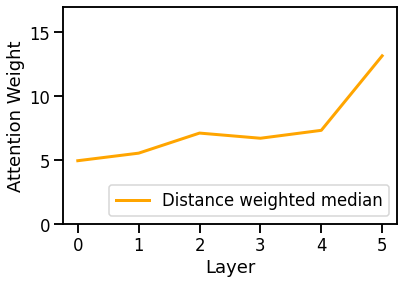

Model:remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


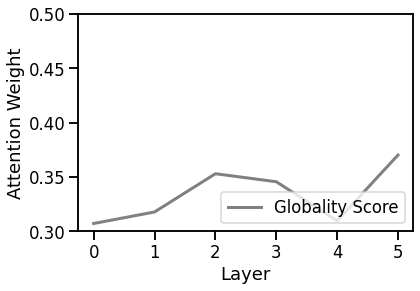

Model:remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


In [185]:
def data_across_lengths(model_results, wanted_focus):
    return np.average(model_results[wanted_focus], weights=list(model_results['lengths_dict'].values()), axis = 0)

for cur_model_path, results in all_models_final_results.items():
    print(cur_model_path)
    display_focus_across_layers(
        (results, 'eos_foucesed_heads'), 'EOS', color='blue')
    display_focus_across_layers(data_across_lengths(results, 'local_heads'), 'Local', color='blue')
    display_focus_across_layers(data_across_lengths(results, 'self_heads'), 'Self', color='blue')
    display_focus_across_layers(data_across_lengths(results, 'distance_weighted_median'), 'Distance weighted median', color='blue')
    display_focus_across_layers(data_across_lengths(results, 'globality_scores'), 'Globality Score', color='blue')
    print("="*100)


# Probe Consistency Prediction

In [3519]:
probe_results_dir = '/checkpoint/itayitzhak/attention_prob_data/'
all_models_results = []

#is_zero_out = False
features_to_use = ''#'all'
train_type = "not_permuted"
all_conditions = [("s_conj","s1_s2","s3_s2"),("s_conj","s1_s2","s1p_s2"),("s_np_vp","np","np_prime"),("s_np_vp","np","vp_prime")]
all_vtype = ['glob_wmd']
all_seeds = [1,2,3,4,5]
text_types = ['synthetic']
#text_types = ['synthetic','semi_natural', 'natural']

for text_type in text_types:
    for vtype in all_vtype:
        for conj_type, first_eval_type, second_eval_type in all_conditions:
            for model in ["random"]:#["xgb", "gbc", "random", "logreg",]:
                for model_seed in all_seeds:
                    #results_file = f"not_permuted_seed_{model_seed}_compositional_mt_systematicity_{conj_type}_synthetic_systematicity_synthetic_1_{first_eval_type}_all_AND_not_permuted_seed_{model_seed}_compositional_mt_systematicity_{conj_type}_synthetic_systematicity_synthetic_1_{second_eval_type}_all_{model}_glob_wmd_results.csv"
                    results_file = f"{train_type}_seed_{model_seed}_compositional_mt_systematicity_{conj_type}_{text_type}_systematicity_{text_type}_{template}_{first_eval_type}_{second_eval_type}_all_{model}_{vtype}{features_to_use}_results.csv"
                    try:
                        all_models_results.append(pd.read_csv(probe_results_dir+results_file)) 
                    except Exception as e:
                        print(e)
all_models_results = pd.concat(all_models_results)

# /checkpoint/itayitzhak/attention_prob_data/not_permuted_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1,2,3,4,5,6,7,8,9,10_s1_s2_s3_s2_all_random_wmd_glob_results.csv

In [3520]:
all_models_results

,Unnamed: 0,Majority accuracy,Confusion matrix,accuracy,precision,f1,recall,matthews_correlation,vtype,model,seed,probe_train_size,train_type,model_seed,test_type,conj_type,text_type,template,first_eval_type,second_eval_type,train_size
0,0,0.500000,pr...,0.700000,0.722222,0.684211,0.650000,0.402015,glob_wmd,random,42,1438,not_permuted,1,systematicity,s_conj,synthetic,"1,2,3,4,5,6,7,8,...",s1_s2,s3_s2,all
1,1,0.500000,pr...,0.706250,0.732394,0.688742,0.650000,0.415135,glob_wmd,random,42,1438,not_permuted,1,systematicity,s_conj,synthetic,"1,2,3,4,5,6,7,8,...",s1_s2,s3_s2,all
2,2,0.500000,pr...,0.718750,0.746479,0.701987,0.662500,0.440295,glob_wmd,random,42,1438,not_permuted,1,systematicity,s_conj,synthetic,"1,2,3,4,5,6,7,8,...",s1_s2,s3_s2,all
3,3,0.500000,pr...,0.706250,0.732394,0.688742,0.650000,0.415135,glob_wmd,random,42,1438,not_permuted,1,systematicity,s_conj,synthetic,"1,2,3,4,5,6,7,8,...",s1_s2,s3_s2,all
4,4,0.500000,pr...,0.756250,0.780822,0.745098,0.712500,0.514473,glob_wmd,random,42,1438,not_permuted,1,systematicity,s_conj,synthetic,"1,2,3,4,5,6,7,8,...",s1_s2,s3_s2,all
0,0,0.500000,pr...,0.742718,0.735849,0.746411,0.757282,0.485643,glob_wmd,random,42,1846,not_permuted,2,systematicity,s_conj,synthetic,"1,2,3,4,5,6,7,8,...",s1_s2,s3_s2,all
1,1,0.500000,pr...,0.752427,0.745283,0.755981,0.766990,0.505069,glob_wmd,random,42,1846,not_permuted,2,systematicity,s_conj,synthetic,"1,2,3,4,5,6,7,8,...",s1_s2,s3_s2,all
2,2,0.500000,pr...,0.703883,0.705882,0.702439,0.699029,0.407786,glob_wmd,random,42,1846,not_permuted,2,systematicity,s_conj,synthetic,"1,2,3,4,5,6,7,8,...",s1_s2,s3_s2,all
3,3,0.500000,pr...,0.762136,0.750000,0.767773,0.786408,0.524891,glob_wmd,random,42,1846,not_permuted,2,systematicity,s_conj,synthetic,"1,2,3,4,5,6,7,8,...",s1_s2,s3_s2,all
4,4,0.500000,pr...,0.752427,0.736364,0.760563,0.786408,0.506024,glob_wmd,random,42,1846,not_permuted,2,systematicity,s_conj,synthetic,"1,2,3,4,5,6,7,8,...",s1_s2,s3_s2,all


In [1060]:
for second_eval_type, conf in zip(all_models_results['second_eval_type'],all_models_results['Confusion matrix']):
    print(second_eval_type)
    print(conf)

s3_s2
              precision    recall  f1-score   support

         0.0       0.68      0.75      0.71        80
         1.0       0.72      0.65      0.68        80

    accuracy                           0.70       160
   macro avg       0.70      0.70      0.70       160
weighted avg       0.70      0.70      0.70       160

s3_s2
              precision    recall  f1-score   support

         0.0       0.69      0.76      0.72        80
         1.0       0.73      0.65      0.69        80

    accuracy                           0.71       160
   macro avg       0.71      0.71      0.71       160
weighted avg       0.71      0.71      0.71       160

s3_s2
              precision    recall  f1-score   support

         0.0       0.70      0.78      0.73        80
         1.0       0.75      0.66      0.70        80

    accuracy                           0.72       160
   macro avg       0.72      0.72      0.72       160
weighted avg       0.72      0.72      0.72       160

s

In [1140]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
all_models_results = all_models_results[all_models_results['model']=='random']
xd = all_models_results.groupby(['conj_type','first_eval_type','second_eval_type','model']).mean().round(2)
#xd = all_models_results.round(3)
#xd[['accuracy', 'precision','f1','recall','matthews_correlation']]
xd[['Majority accuracy', 'accuracy', 'precision','f1','recall']]

Majority accuracy  \
conj_type first_eval_type second_eval_type model                       
s_conj    s1_s2           s1p_s2           random                0.5   
                          s3_s2            random                0.5   
s_np_vp   np              np_prime         random                0.5   
                          vp_prime         random                0.5   

                                                   accuracy  precision    f1  \
conj_type first_eval_type second_eval_type model                               
s_conj    s1_s2           s1p_s2           random      0.71       0.71  0.70   
                          s3_s2            random      0.73       0.73  0.73   
s_np_vp   np              np_prime         random      0.73       0.73  0.73   
                          vp_prime         random      0.78       0.79  0.78   

                                                   recall  
conj_type first_eval_type second_eval_type model           
s_conj    s1_s2           s1p_s2           random    0.70  
                          s3_s2            random    0.74  
s_np_vp   np              np_prime         random    0.73  
                          vp_prime         random    0.78

In [1141]:
print(xd[['accuracy', 'precision','f1','recall']].to_latex(index=True))

\begin{tabular}{llllrrrr}
\toprule
        &    &          &        &  accuracy &  precision &    f1 &  recall \\
conj\_type & first\_eval\_type & second\_eval\_type & model &           &            &       &         \\
\midrule
s\_conj & s1\_s2 & s1p\_s2 & random &      0.71 &       0.71 &  0.70 &    0.70 \\
        &    & s3\_s2 & random &      0.73 &       0.73 &  0.73 &    0.74 \\
s\_np\_vp & np & np\_prime & random &      0.73 &       0.73 &  0.73 &    0.73 \\
        &    & vp\_prime & random &      0.78 &       0.79 &  0.78 &    0.78 \\
\bottomrule
\end{tabular}



### Training probe with all conditions at once

In [3106]:
probe_results_dir = '/checkpoint/itayitzhak/attention_prob_data/'
unified_all_models_results = []

# not_permuted_seed_1_compositional_mt_systematicity_s_conj,s_conj,s_np_vp,s_np_vp_synthetic_systematicity_synthetic_1,2,3,4,5,6,7,8,9,10_s1_s2,s1_s2,np,np_s3_s2,s1p_s2,np_prime,vp_prime_all_random_glob_wmd_results.csv
#all_conditions = [("s_conj","s1_s2","s3_s2")]
#train_type = "not_permuted"
train_types = ["remove_eos_not_permuted"]#["remove_eos_not_permuted","not_permuted"]
all_vtype = ['glob_wmd','wrong_compute_permute','wrong_compute_ones','wrong_compute_one_weight']#['wrong_compute_permute','glob_wmd']#['glob_wmd_aal']#['glob','wmd','glob_wmd']##
conj_type = "s_conj,s_conj"
first_eval_type = "s1_s2,s1_s2"
second_eval_type = "s3_s2,s1p_s2"
# conj_type = "s_conj,s_conj,s_np_vp,s_np_vp"
# first_eval_type = "s1_s2,s1_s2,np,np"
# second_eval_type = "s3_s2,s1p_s2,np_prime,vp_prime"
template = "1,2,3,4,5,6,7,8,9,10"
text_types = ['synthetic']#['synthetic', 'semi_natural', 'natural']
all_layers_to_disregard = [""]#["1,2,3,4,5"]#["","0,1,2,3,4,5", "3,4,5"]
all_features_to_use = ["all", '2ARD', "MEAN_ARD"]#["","all","2ARD,2MAD", "2ARD", "2MAD", "MEAN_ARD", "MUL_ARD"]
#all_features_to_use = ["all", "all_AAL", "4AAL", "2AALleft", "2AALright", "1AALright", "1AALleft"]#["","all","2ARD,2MAD", "2ARD", "2MAD", "MEAN_ARD", "MUL_ARD"]

model_seeds = [1,2,3,4,5]
linear_model_names = ["random", "logreg"] #["random", "logreg","xgb"]

for train_type in train_types:
    for features_to_use in all_features_to_use:
        for layers_to_disregard in all_layers_to_disregard:
            for text_type in text_types:
                for vtype in all_vtype:
                    for model in linear_model_names :
                        for model_seed in model_seeds:
                            results_file = f"{train_type}_seed_{model_seed}_compositional_mt_systematicity_{conj_type}_{text_type}_systematicity_{text_type}_{template}_{first_eval_type}_{second_eval_type}_all_{model}_{vtype}{layers_to_disregard}{features_to_use}_results"
                            try:
                                unified_all_models_results.append(pd.read_pickle(f"{probe_results_dir+results_file}.pkl"))
                                #unified_all_models_results.append(pd.read_csv(probe_results_dir+results_file+'.csv')) 
                            except Exception as e:
                                print(str(e).replace('[Errno 2] No such file or directory: \'/checkpoint/itayitzhak/attention_prob_data/',''))
unified_all_models_results = pd.concat(unified_all_models_results)

remove_eos_not_permuted_seed_1_compositional_mt_systematicity_s_conj,s_conj_synthetic_systematicity_synthetic_1,2,3,4,5,6,7,8,9,10_s1_s2,s1_s2_s3_s2,s1p_s2_all_random_glob_wmdMEAN_ARD_results.pkl'
remove_eos_not_permuted_seed_2_compositional_mt_systematicity_s_conj,s_conj_synthetic_systematicity_synthetic_1,2,3,4,5,6,7,8,9,10_s1_s2,s1_s2_s3_s2,s1p_s2_all_random_glob_wmdMEAN_ARD_results.pkl'
remove_eos_not_permuted_seed_3_compositional_mt_systematicity_s_conj,s_conj_synthetic_systematicity_synthetic_1,2,3,4,5,6,7,8,9,10_s1_s2,s1_s2_s3_s2,s1p_s2_all_random_glob_wmdMEAN_ARD_results.pkl'
remove_eos_not_permuted_seed_4_compositional_mt_systematicity_s_conj,s_conj_synthetic_systematicity_synthetic_1,2,3,4,5,6,7,8,9,10_s1_s2,s1_s2_s3_s2,s1p_s2_all_random_glob_wmdMEAN_ARD_results.pkl'
remove_eos_not_permuted_seed_5_compositional_mt_systematicity_s_conj,s_conj_synthetic_systematicity_synthetic_1,2,3,4,5,6,7,8,9,10_s1_s2,s1_s2_s3_s2,s1p_s2_all_random_glob_wmdMEAN_ARD_results.pkl'
remove_eos_not_

In [3095]:
unified_all_models_results

,Majority accuracy,Confusion matrix,accuracy,precision,f1,recall,matthews_correlation,sam_1_glob_0,sam_1_glob_1,sam_2_glob_0,sam_2_glob_1,sam_1_wmd_0,sam_1_wmd_1,sam_2_wmd_0,sam_2_wmd_1,gt_sam_1_glob_0,gt_sam_1_glob_1,gt_sam_2_glob_0,gt_sam_2_glob_1,gt_sam_1_wmd_0,gt_sam_1_wmd_1,gt_sam_2_wmd_0,gt_sam_2_wmd_1,logreg_coef,logreg_intercept,features_to_use,vtype,model,seed,probe_train_size,train_type,model_seed,test_type,conj_type,text_type,template,first_eval_type,second_eval_type,train_size,first_feature_0,first_feature_1,second_feature_0,second_feature_1
0,0.500000,pr...,0.759843,0.746269,0.766284,0.787402,0.520476,[0.0569957630049...,[0.0562266228162...,[0.0569932584755...,[0.0561706627541...,[0.0016666666666...,[0.0007462686567...,[0.0008333333333...,"[0.0, 2.29179104...",[0.0572016910343...,[0.0559783012332...,[0.0570506057339...,[0.0560679755740...,[0.0015748031496...,[0.0007874015748...,[0.0007874015748...,"[0.0, 2.25354330...",None,None,all,glob_wmd,random,42,2284,remove_eos_not_p...,1,systematicity,"s_conj,s_conj",synthetic,"1,2,3,4,5,6,7,8,...","s1_s2,s1_s2","s3_s2,s1p_s2",all,NaN,NaN,NaN,NaN
1,0.500000,pr...,0.751969,0.722222,0.767528,0.818898,0.508513,[0.0569916410829...,[0.0562831840197...,[0.0569535479889...,[0.0562581218564...,[0.0018181818181...,[0.0006944444444...,[0.0009090909090...,"[0.0, 2.31666666...",[0.0572016910343...,[0.0559783012332...,[0.0570506057339...,[0.0560679755740...,[0.0015748031496...,[0.0007874015748...,[0.0007874015748...,"[0.0, 2.25354330...",None,None,all,glob_wmd,random,42,2284,remove_eos_not_p...,1,systematicity,"s_conj,s_conj",synthetic,"1,2,3,4,5,6,7,8,...","s1_s2,s1_s2","s3_s2,s1p_s2",all,NaN,NaN,NaN,NaN
2,0.500000,pr...,0.744094,0.731343,0.750958,0.771654,0.488932,[0.0570114604601...,[0.0562125653937...,[0.0568474636556...,[0.0563012252793...,[0.0016666666666...,[0.0007462686567...,[0.0008333333333...,"[0.0, 2.22388059...",[0.0572016910343...,[0.0559783012332...,[0.0570506057339...,[0.0560679755740...,[0.0015748031496...,[0.0007874015748...,[0.0007874015748...,"[0.0, 2.25354330...",None,None,all,glob_wmd,random,42,2284,remove_eos_not_p...,1,systematicity,"s_conj,s_conj",synthetic,"1,2,3,4,5,6,7,8,...","s1_s2,s1_s2","s3_s2,s1p_s2",all,NaN,NaN,NaN,NaN
3,0.500000,pr...,0.708661,0.705426,0.710938,0.716535,0.417375,[0.0567993468420...,[0.0563871369202...,[0.0567867696297...,[0.0563388652898...,[0.0015999999999...,[0.0007751937984...,[0.0008000000000...,"[0.0, 2.32248062...",[0.0572016910343...,[0.0559783012332...,[0.0570506057339...,[0.0560679755740...,[0.0015748031496...,[0.0007874015748...,[0.0007874015748...,"[0.0, 2.25354330...",None,None,all,glob_wmd,random,42,2284,remove_eos_not_p...,1,systematicity,"s_conj,s_conj",synthetic,"1,2,3,4,5,6,7,8,...","s1_s2,s1_s2","s3_s2,s1p_s2",all,NaN,NaN,NaN,NaN
4,0.500000,pr...,0.736220,0.727273,0.741313,0.755906,0.472808,[0.0572906535851...,[0.0559424187922...,[0.0572296718856...,[0.0559396958792...,[0.0016393442622...,[0.0007575757575...,[0.0008196721311...,"[0.0, 2.25151515...",[0.0572016910343...,[0.0559783012332...,[0.0570506057339...,[0.0560679755740...,[0.0015748031496...,[0.0007874015748...,[0.0007874015748...,"[0.0, 2.25354330...",None,None,all,glob_wmd,random,42,2284,remove_eos_not_p...,1,systematicity,"s_conj,s_conj",synthetic,"1,2,3,4,5,6,7,8,...","s1_s2,s1_s2","s3_s2,s1p_s2",all,NaN,NaN,NaN,NaN
0,0.501742,pr...,0.770035,0.786765,0.764286,0.743056,0.540994,[0.1673620645252...,[0.1660828487947...,[0.1660782997559...,[0.1647879842979...,[2.5377483443708...,[2.3580882352941...,[2.4165562913907...,[2.4588235294117...,[0.1667976307468...,[0.1667144304347...,[0.1652814968189...,[0.1656509380733...,[2.4699300699300...,[2.4354166666666...,[2.4139860139860...,[2.4590277777777...,None,None,all,glob_wmd,random,42,2580,remove_eos_not_p...,2,systematicity,"s_conj,s_conj",synthetic,"1,2,3,4,5,6,7,8,...","s1_s2,s1_s2","s3_s2,s1p_s2",all,NaN,NaN,NaN,NaN
1,0.501742,pr...,0.787456,0.794326,0.785965,0.777778,0.575064,[0.1670188956007...,[0.1664835490900...,

In [3107]:
all_logreg_coef = []
all_logreg_intercept = []
all_accuracy = []
features_to_check = '2ARD'
log_reg_unified_all_models_results = unified_all_models_results[unified_all_models_results['model']=='logreg']
for index, row in log_reg_unified_all_models_results.iterrows():
    if row['features_to_use']==features_to_check:
        all_logreg_coef.extend(row['logreg_coef'])
        all_logreg_intercept.extend(row['logreg_intercept'])
        all_accuracy.extend([row['accuracy']])
#print(all_logreg_coef)
print(f"{features_to_check}")
print(f"logreg.coef = {np.mean(np.array(all_logreg_coef),axis=0).round(2)}")
print(f"logreg.intercept = {np.mean(np.array(all_logreg_intercept),axis=0).round(2)}")
print(f"accuracy = {np.mean(all_accuracy).round(2)}")

print(f"logreg.coef = {np.array(all_logreg_coef).round(2)}")
print(f"logreg.intercept = {np.array(all_logreg_intercept).round(2)}")
print(f"accuracy = {np.array(all_accuracy).round(2)}")

2ARD
logreg.coef = [-0.22 -0.17]
logreg.intercept = 0.05
accuracy = 0.5
logreg.coef = [[ 0.27  0.53]
 [ 0.27  0.53]
 [-0.57 -0.21]
 [-0.57 -0.21]
 [-0.31 -0.21]
 [-0.31 -0.21]
 [-0.15 -0.16]
 [-0.15 -0.16]
 [ 0.18 -0.62]
 [ 0.18 -0.62]
 [-0.01  0.31]
 [-0.01  0.31]
 [-0.42  0.19]
 [-0.42  0.19]
 [-0.4  -0.14]
 [-0.4  -0.14]
 [-0.16  0.07]
 [-0.16  0.07]
 [-0.09 -0.35]
 [-0.09 -0.35]
 [-0.01  0.02]
 [-0.01  0.02]
 [-0.48 -0.45]
 [-0.48 -0.45]
 [-0.31 -0.33]
 [-0.31 -0.33]
 [-0.27 -0.28]
 [-0.27 -0.28]
 [-0.08 -0.19]
 [-0.08 -0.19]
 [ 0.01 -0.15]
 [ 0.01 -0.15]
 [-0.79 -0.69]
 [-0.79 -0.69]
 [-0.37 -0.43]
 [-0.37 -0.43]
 [-0.35 -0.31]
 [-0.35 -0.31]
 [-0.16 -0.02]
 [-0.16 -0.02]]
logreg.intercept = [-0.19 -0.19  0.19  0.19  0.13  0.13  0.07  0.07  0.1   0.1  -0.11 -0.11
  0.09  0.09  0.2   0.2   0.04  0.04  0.16  0.16 -0.   -0.    0.05  0.05
  0.03  0.03  0.03  0.03  0.01  0.01  0.01  0.01  0.08  0.08  0.04  0.04
  0.04  0.04  0.01  0.01]
accuracy = [0.43 0.43 0.51 0.51 0.53 0.53 0.53 0.

In [3109]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#uni_xd = unified_all_models_results.groupby(['model', 'vtype']).mean().round(3)
uni_xd = unified_all_models_results.groupby(['text_type','model','features_to_use','train_type','vtype']).mean().round(2)
uni_xd = uni_xd.replace('remove_eos_not_permuted', 'Baseline Without EOS')
#xd = all_models_results.round(3)
#xd[['accuracy', 'precision','f1','recall','matthews_correlation']]
uni_xd[['Majority accuracy', 'accuracy', 'precision','f1','recall']]

Majority accuracy  \
text_type model  features_to_use train_type           vtype                                     
synthetic logreg 2ARD            remove_eos_not_pe... glob_wmd                            0.5   
                                                      wrong_compute_one...                0.5   
                                                      wrong_compute_ones                  0.5   
                                                      wrong_compute_per...                0.5   
                 all             remove_eos_not_pe... glob_wmd                            0.5   
                                                      wrong_compute_one...                0.5   
                                                      wrong_compute_ones                  0.5   
                                                      wrong_compute_per...                0.5   
          random 2ARD            remove_eos_not_pe... glob_wmd                            0.5   
                                                      wrong_compute_one...                0.5   
                                                      wrong_compute_ones                  0.5   
                                                      wrong_compute_per...                0.5   
                 all             remove_eos_not_pe... glob_wmd                            0.5   
                                                      wrong_compute_one...                0.5   
                                                      wrong_compute_ones                  0.5   
                                                      wrong_compute_per...                0.5   

                                                                            accuracy  \
text_type model  features_to_use train_type           vtype                            
synthetic logreg 2ARD            remove_eos_not_pe... glob_wmd                  0.50   
                                                      wrong_compute_one...      0.54   
                                                      wrong_compute_ones        0.49   
                                                      wrong_compute_per...      0.50   
                 all             remove_eos_not_pe... glob_wmd                  0.57   
                                                      wrong_compute_one...      0.57   
                                                      wrong_compute_ones        0.51   
                                                      wrong_compute_per...      0.56   
          random 2ARD            remove_eos_not_pe... glob_wmd                  0.68   
                                                      wrong_compute_one...      0.70   
                                                      wrong_compute_ones        0.52   
                                                      wrong_compute_per...      0.67   
                 all             remove_eos_not_pe... glob_wmd                  0.76   
                                                      wrong_compute_one...      0.74   
                                                      wrong_compute_ones        0.52   
                                                      wrong_compute_per...      0.73   

                                                                            precision  \
text_type model  features_to_use train_type           vtype                             
synthetic logreg 2ARD            remove_eos_not_pe... glob_wmd                   0.50   
                                                      wrong_compute_one...       0.53   
                                                      wrong_compute_ones         0.49   
                                                      wrong_compute_per...       0.50   
                 all             remove_eos_not_pe... glob_wmd                   0.57   
                                                      wrong_compute_one...       0.57   
                                

In [3070]:
print(uni_xd[['accuracy', 'precision','f1','recall']].to_latex(index=True)) 

\begin{tabular}{lllllrrrr}
\toprule
                      &           &        &     &                         &  accuracy &  precision &    f1 &  recall \\
vtype & text\_type & model & features\_to\_use & train\_type &           &            &       &         \\
\midrule
wrong\_compute\_ones & synthetic & logreg & 2ARD & remove\_eos\_not\_permuted &      0.49 &       0.49 &  0.53 &    0.59 \\
                      &           &        & all & remove\_eos\_not\_permuted &      0.51 &       0.51 &  0.55 &    0.61 \\
                      &           & random & 2ARD & remove\_eos\_not\_permuted &      0.52 &       0.52 &  0.53 &    0.53 \\
                      &           &        & all & remove\_eos\_not\_permuted &      0.52 &       0.52 &  0.52 &    0.52 \\
wrong\_compute\_permute & natural & logreg & 2ARD & remove\_eos\_not\_permuted &      0.49 &       0.49 &  0.50 &    0.51 \\
                      &           &        & all & remove\_eos\_not\_permuted &      0.53 &       0.53 & 

In [1996]:
# with wmd/10
display_df = unified_all_models_results.copy()
#filter_1 = display_df['vtype']=='glob_wmd'
filter_2 = display_df['features_to_use']=='all'
display_df = display_df[filter_2]
# #pd.set_option("display.max_rows", None, "display.max_columns", None)

uni_xd = display_df.groupby(['text_type','model','vtype', 'train_type']).mean().round(2)
#xd = all_models_results.round(2)
#xd[['accuracy', 'precision','f1','recall','matthews_correlation']]
uni_xd[['accuracy', 'precision','f1','recall']]

accuracy  precision    f1  \
text_type model  vtype        train_type                                        
natural   logreg aal          not_permuted              0.54       0.54  0.55   
                              remove_eos_not_pe...      0.55       0.55  0.55   
                 glob_wmd_aal not_permuted              0.54       0.54  0.55   
                              remove_eos_not_pe...      0.54       0.54  0.55   
          random aal          not_permuted              0.75       0.72  0.76   
                              remove_eos_not_pe...      0.75       0.72  0.76   
                 glob_wmd_aal not_permuted              0.75       0.73  0.76   
                              remove_eos_not_pe...      0.76       0.74  0.77   
synthetic logreg aal          not_permuted              0.67       0.71  0.63   
                              remove_eos_not_pe...      0.66       0.70  0.62   
                 glob_wmd_aal not_permuted              0.67       0.70  0.64   
                              remove_eos_not_pe...      0.67       0.70  0.64   
          random aal          not_permuted              0.74       0.86  0.68   
                              remove_eos_not_pe...      0.73       0.85  0.67   
                 glob_wmd_aal not_permuted              0.77       0.80  0.76   
                              remove_eos_not_pe...      0.76       0.80  0.75   

                                                    recall  
text_type model  vtype        train_type                    
natural   logreg aal          not_permuted            0.56  
                              remove_eos_not_pe...    0.56  
                 glob_wmd_aal not_permuted            0.55  
                              remove_eos_not_pe...    0.56  
          random aal          not_permuted            0.81  
                              remove_eos_not_pe...    0.81  
                 glob_wmd_aal not_permuted            0.78  
                              remove_eos_not_pe...    0.80  
synthetic logreg aal          not_permuted            0.57  
                              remove_eos_not_pe...    0.56  
                 glob_wmd_aal not_permuted            0.60  
                              remove_eos_not_pe...    0.59  
          random aal          not_permuted            0.57  
                              remove_eos_not_pe...    0.56  
                 glob_wmd_aal not_permuted            0.73  
                              remove_eos_not_pe...    0.71

In [1701]:
thin_unified_all_models_results = unified_all_models_results[(unified_all_models_results['model']=='random') & (unified_all_models_results['vtype']=='glob_wmd')]
uni_xd = thin_unified_all_models_results.groupby(['text_type']).mean().round(2)
#xd = all_models_results.round(2)
#xd[['accuracy', 'precision','f1','recall','matthews_correlation']]


In [1702]:
print(uni_xd[['accuracy', 'precision','f1','recall']].to_latex(index=True)) 

\begin{tabular}{lrrrr}
\toprule
{} &  accuracy &  precision &    f1 &  recall \\
text\_type &           &            &       &         \\
\midrule
synthetic &      0.77 &       0.79 &  0.75 &    0.72 \\
\bottomrule
\end{tabular}



### Histograms for probe results

In [1417]:
filter_1 = unified_all_models_results['model']=='logreg'
filter_2 = unified_all_models_results['vtype']=='glob_wmd'
filter_3 = unified_all_models_results['text_type']=='synthetic'
thin_unified_all_models_results = unified_all_models_results[filter_1 & filter_2 & filter_3]
thin_unified_all_models_results

,Majority accuracy,Confusion matrix,accuracy,precision,f1,recall,matthews_correlation,sam_1_glob_0,sam_1_glob_1,sam_2_glob_0,sam_2_glob_1,sam_1_wmd_0,sam_1_wmd_1,sam_2_wmd_0,sam_2_wmd_1,gt_sam_1_glob_0,gt_sam_1_glob_1,gt_sam_2_glob_0,gt_sam_2_glob_1,gt_sam_1_wmd_0,gt_sam_1_wmd_1,gt_sam_2_wmd_0,gt_sam_2_wmd_1,vtype,model,seed,probe_train_size,train_type,model_seed,test_type,conj_type,text_type,template,first_eval_type,second_eval_type,train_size,logreg_coef,logreg_intercept,features_to_use,logreg_stat_significance,first_feature_0,first_feature_1,second_feature_0,second_feature_1,third_feature_0,third_feature_1,forth_feature_0,forth_feature_1
0,0.500000,precision recall f1-score ...,0.687629,0.708716,0.671010,0.637113,0.377188,"[5.073228776529334, 4.981253901373282]","[9.385182530581044, 9.051868310397548]",[],[],[],[],[],[],"[6.2483891752577305, 6.122753436426118]","[7.774381443298973, 7.499110824742263]",[],[],[],[],[],[],glob_wmd,logreg,42,8721,not_permuted,1,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[0.34263003735352, -0.031625930952391836]]",[-2.1331914150076687],2MAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.500000,precision recall f1-score ...,0.687629,0.708716,0.671010,0.637113,0.377188,"[5.073228776529334, 4.981253901373282]","[9.385182530581044, 9.051868310397548]",[],[],[],[],[],[],"[6.2483891752577305, 6.122753436426118]","[7.774381443298973, 7.499110824742263]",[],[],[],[],[],[],glob_wmd,logreg,42,8721,not_permuted,1,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[0.34263003735352, -0.031625930952391836]]",[-2.1331914150076687],2MAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.500000,precision recall f1-score ...,0.687629,0.708716,0.671010,0.637113,0.377188,"[5.073228776529334, 4.981253901373282]","[9.385182530581044, 9.051868310397548]",[],[],[],[],[],[],"[6.2483891752577305, 6.122753436426118]","[7.774381443298973, 7.499110824742263]",[],[],[],[],[],[],glob_wmd,logreg,42,8721,not_permuted,1,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[0.34263003735352, -0.031625930952391836]]",[-2.1331914150076687],2MAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.500000,precision recall f1-score ...,0.687629,0.708716,0.671010,0.637113,0.377188,"[5.073228776529334, 4.981253901373282]","[9.385182530581044, 9.051868310397548]",[],[],[],[],[],[],"[6.2483891752577305, 6.122753436426118]","[7.774381443298973, 7.499110824742263]",[],[],[],[],[],[],glob_wmd,logreg,42,8721,not_permuted,1,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[0.34263003735352, -0.031625930952391836]]",[-2.1331914150076687],2MAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.500000,precision recall f1-score ...,0.687629,0.708716,0.671010,0.637113,0.377188,"[5.073228776529334, 4.981253901373282]","[9.385182530581044, 9.051868310397548]",[],[],[],[],[],[],"[6.2483891752577305, 6.122753436426118]","[7.774381443298973, 7.499110824742263]",[],[],[],[],[],[],glob_wmd,logreg,42,8721,not_permuted,1,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[0.34263003735352, -0.031625930952391836]]",[-2.1331914150076687],2MAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.500000,precision recall f1-score ...,0.640267,0.664430,0.611740,0.566794,0.283613,"[4.85930393788131, 4.7238803383250145]","[8.972226882923204, 8.726896905294563]",[],[],[],[],[],[],"[6.039233460559801, 5.871982347328251]","[7.187917461832068, 6.99056536259542]",[],[],[],[],[],[],glob_wmd,logreg,42,9429,not_permuted,2,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[0.30686335352653626, -0.043629900

In [1418]:
thin_unified_all_models_results[thin_unified_all_models_results['features_to_use']=='2ARD']

,Majority accuracy,Confusion matrix,accuracy,precision,f1,recall,matthews_correlation,sam_1_glob_0,sam_1_glob_1,sam_2_glob_0,sam_2_glob_1,sam_1_wmd_0,sam_1_wmd_1,sam_2_wmd_0,sam_2_wmd_1,gt_sam_1_glob_0,gt_sam_1_glob_1,gt_sam_2_glob_0,gt_sam_2_glob_1,gt_sam_1_wmd_0,gt_sam_1_wmd_1,gt_sam_2_wmd_0,gt_sam_2_wmd_1,vtype,model,seed,probe_train_size,train_type,model_seed,test_type,conj_type,text_type,template,first_eval_type,second_eval_type,train_size,logreg_coef,logreg_intercept,features_to_use,logreg_stat_significance,first_feature_0,first_feature_1,second_feature_0,second_feature_1,third_feature_0,third_feature_1,forth_feature_0,forth_feature_1
0,0.500000,precision recall f1-score ...,0.668041,0.673036,0.663180,0.653608,0.336223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,glob_wmd,logreg,42,8721,not_permuted,1,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[-10.974558086782977, -4.6413596626456926]]",[4.825398159075273],2ARD,"[0.0, 0.0, 4.04121180963557e-14]","[0.31100092038536364, 0.33741036706906735, 0.3...","[0.2899001494405297, 0.28179593510393486, 0.37...","[0.30976138410874315, 0.33698162352673444, 0.3...","[0.29365656455021766, 0.2885217726111549, 0.18...",NaN,NaN,NaN,NaN
0,0.500000,precision recall f1-score ...,0.625954,0.633065,0.615686,0.599237,0.252269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,glob_wmd,logreg,42,9429,not_permuted,2,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[-9.717450755079328, -3.793282243601738]]",[4.160518286721186],2ARD,"[0.0, 0.0, 6.36275476750825e-11]","[0.285712916673785, 0.2821182150114498, 0.3378...","[0.3326398616437595, 0.32802896104395596, 0.36...","[0.2900779040203929, 0.2887478983085413, 0.342...","[0.3339767067795725, 0.3294969702439409, 0.362...",NaN,NaN,NaN,NaN
0,0.500000,precision recall f1-score ...,0.626938,0.633401,0.617676,0.602713,0.254174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,glob_wmd,logreg,42,9282,not_permuted,3,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[-10.957474608947837, -3.279016823625408]]",[4.371723551457357],2ARD,"[0.0, 0.0, 1.3072084747989265e-08]","[0.2807119824605014, 0.35464001792537464, 0.33...","[0.27633973626849334, 0.320756192753203, 0.273...","[0.27958652404320616, 0.35513228109017475, 0.3...","[0.13869203859546073, 0.32031431507849917, 0.2...",NaN,NaN,NaN,NaN
0,0.499490,precision recall f1-score ...,0.642202,0.656885,0.623794,0.593878,0.285648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,glob_wmd,logreg,42,8827,not_permuted,4,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[-11.207604175490207, -3.1159781772915007]]",[4.3416235163391725],2ARD,"[0.0, 0.0, 2.5106688217313433e-07]","[0.2628923564093439, 0.3259425944250382, 0.318...","[0.3278184435742883, 0.2833900374787695, 0.268...","[0.2640023310996442, 0.3371225239178883, 0.152...","[0.3330282460294693, 0.2729167320080639, 0.265...",NaN,NaN,NaN,NaN
0,0.499478,precision recall f1-score ...,0.645768,0.668281,0.619529,0.577406,0.294162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,glob_wmd,logreg,42,8613,not_permuted,5,systematicity,"s_conj,s_conj,s_np_vp,s_np_vp",synthetic,"1,2,3,4,5,6,7,8,9,10","s1_s2,s1_s2,np,np","s3_s2,s1p_s2,np_prime,vp_prime",all,"[[-12.245435935654028, -3.987859835011782]]",[5.0895149318418955],2ARD,"[0.0, 0.0, 1.9268586726184367e-11]","[0.33769031979493375, 0.31622453622691654, 0.2...","[0.2820421406131929, 0.34421625657013194, 0.29...","[0.33887617774301404, 0.3110851551242231, 0.28...","[0.2810863130362102, 0.34395773505005095, 0.28...",NaN,NaN,NaN,NaN


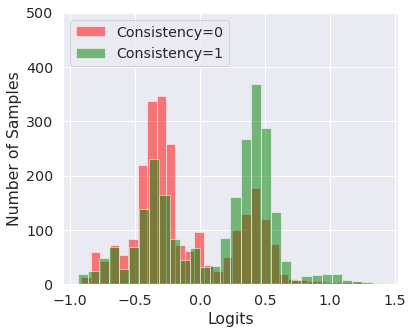

In [1426]:
logits_0 = []
logits_1 = []
for index, row in thin_unified_all_models_results[thin_unified_all_models_results['features_to_use']=='2ARD'].iterrows():    
    log_coef = row['logreg_coef'][0]
    logit_0 = log_coef[0] * row['first_feature_0'] + log_coef[1] * row['second_feature_0'] + row['logreg_intercept']
    logits_0.extend(logit_0)
    logit_1 = log_coef[0] * row['first_feature_1'] + log_coef[1] * row['second_feature_1'] + row['logreg_intercept']
    logits_1.extend(logit_1)
    #print(logit_0)
    #print(logit_1)

plt.hist(logits_0, bins=30, alpha=0.5, label=f"Consistency=0", histtype='bar', color='red')
plt.hist(logits_1, bins=30, alpha=0.5, label=f"Consistency=1", histtype='bar', color='green')

plt.legend(loc='upper left')
plt.ylabel('Number of Samples')
plt.xlabel(f'Logits')
plt.ylim(0,500)
#plt.xlim(x_lim[0],x_lim[1])


#plt.title(f"systematicity | {data_size} | {model_results['text_type']} | {model_results['conj_type']} | {model_results['eval_type']}")
analysis_results_dir = '/checkpoint/itayitzhak/attn_weigths/results/'
plt.savefig(analysis_results_dir+f"histogram_logreg_logits.pdf")
#plt.show()


In [1396]:
def plot_hist_from_prob(cur_df, score_name, is_probe_pred, y_type, agg_type='None', x_lim=(0.0,1.0), y_lim=(0,300)):
    sns.set(font_scale=1.3)
    
    if agg_type=='Sum':
        agg_func = lambda x,y:x+y
    if agg_type=='Mean':
        agg_func = lambda x,y:(x+y)/2
    if agg_type=='Subtraction':
        agg_func = lambda x,y:abs(x-y)
    if agg_type=='Multipication':
        agg_func = lambda x,y:x*y
    
    if is_probe_pred:
        prefix = ""
    else:
        prefix = "gt_"
        
#     for index, row in cur_df.iterrows():
#         #print(row)
#         if agg_type == 'None':# gt_sam_1_glob_0
#             data_to_plot.extend(row[f"{prefix}sam_1_{score_name}_{y_type}"])
#         else:
#             data_to_plot.extend(agg_func(
#                 row[f"{prefix}sam_1_{score_name}_{y_type}"],
#                 row[f"{prefix}sam_2_{score_name}_{y_type}"]))
    
    y_type = 0
    data_to_plot_0 = []
    for index, row in cur_df.iterrows():
        #print(row)
        if agg_type == 'None':# gt_sam_1_glob_0
            data_to_plot_0.extend(row[f"{prefix}sam_1_{score_name}_{y_type}"])
        else:
            data_to_plot_0.extend(agg_func(
                row[f"{prefix}sam_1_{score_name}_{y_type}"],
                row[f"{prefix}sam_2_{score_name}_{y_type}"]))
    y_type = 1
    data_to_plot_1 = []
    for index, row in cur_df.iterrows():
        #print(row)
        if agg_type == 'None':# gt_sam_1_glob_0
            data_to_plot_1.extend(row[f"{prefix}sam_1_{score_name}_{y_type}"])
        else:
            data_to_plot_1.extend(agg_func(
                row[f"{prefix}sam_1_{score_name}_{y_type}"],
                row[f"{prefix}sam_2_{score_name}_{y_type}"]))

    if score_name=='glob':
        score_name='ARD'
        color = 'grey'
    if score_name=='wmd':
        score_name='MAD'
        color = 'yellow'
    if is_probe_pred:
        split_type="Prediction="
    else:
        split_type="Consistency="
        
    print_single_ttest(data_to_plot_0,data_to_plot_1,f"Consistency=1",f"Consistency=0")
    U1, p = mannwhitneyu(data_to_plot_0, data_to_plot_1)
    print(len(data_to_plot_0))
    print(len(data_to_plot_1))
    print(f"The Mann-Whitney U rank test scores are: {U1} with p-value <= {p:.5f}")
    
    # trained_data_size = 'all'
    # text_type = 'synthetic'
    # conds = ("s_conj","s1_s2")
    #plot_one_hist(thin_unified_all_models_results['sam_1_glob_0'], 'all', text_type, conds, "ARD")
    # plot_one_hist(df_plots_unified, 'small', text_type, conds, "MAD")
    # plot_one_hist(df_plots_unified, 'all', text_type, conds, "MAD")
    plt.hist(data_to_plot_0, bins=30, alpha=0.5, label=f"{score_name} {split_type}0 {agg_type}", histtype='bar', color='red')
    plt.hist(data_to_plot_1, bins=30, alpha=0.5, label=f"{score_name} {split_type}1 {agg_type}", histtype='bar', color='green')

    plt.legend(loc='upper left')
    plt.ylabel('Number of Heads')
    plt.xlabel(f'{score_name}')
    plt.ylim(y_lim[0],y_lim[1])
    plt.xlim(x_lim[0],x_lim[1])


    #plt.title(f"systematicity | {data_size} | {model_results['text_type']} | {model_results['conj_type']} | {model_results['eval_type']}")
    analysis_results_dir = '/checkpoint/itayitzhak/attn_weigths/results/'
    #plt.savefig(analysis_results_dir+f"histogram_{y_type}_systematicity_{data_size}_{model_results['text_type']}_{model_results['conj_type']}_{model_results['eval_type']}.pdf")
    plt.show()


In [1397]:
sns.set(rc={'figure.figsize':(6,5)})
plot_hist_from_prob(thin_unified_all_models_results, 'glob',False, "1",agg_type='Mean', x_lim=(0.0,0.5), y_lim=(0,110)) 
#plot_hist_from_prob(thin_unified_all_models_results, 'glob',False, "0",agg_type='Mean', x_lim=(0.0,1.0), y_lim=(0,300)) 
plot_hist_from_prob(thin_unified_all_models_results, 'glob',False, "1",agg_type='Multipication', x_lim=(0.0,0.25), y_lim=(0,110)) 
#plot_hist_from_prob(thin_unified_all_models_results, 'glob',False, "0",agg_type='Multipication', x_lim=(0.0,0.25), y_lim=(0,300)) 
plot_hist_from_prob(thin_unified_all_models_results, 'glob',False, "1",agg_type='Sum', x_lim=(0.0,1.0), y_lim=(0,300)) 
#plot_hist_from_prob(thin_unified_all_models_results, 'glob',False, "0",agg_type='Sum', x_lim=(0.0,1.0), y_lim=(0,300)) 
plot_hist_from_prob(thin_unified_all_models_results, 'glob',False, "1",agg_type='Subtraction', x_lim=(-0.01,0.04), y_lim=(0,400)) 
#plot_hist_from_prob(thin_unified_all_models_results, 'glob',False, "0",agg_type='Subtraction', x_lim=(-0.01,0.04), y_lim=(0,350)) 

ValueError: operands could not be broadcast together with shapes (2,) (0,) 

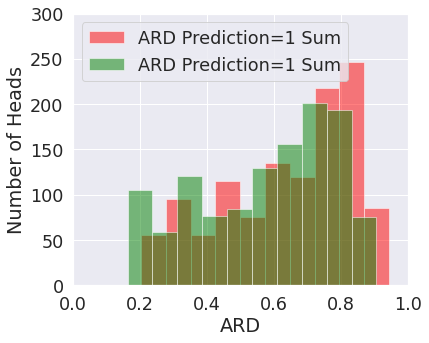

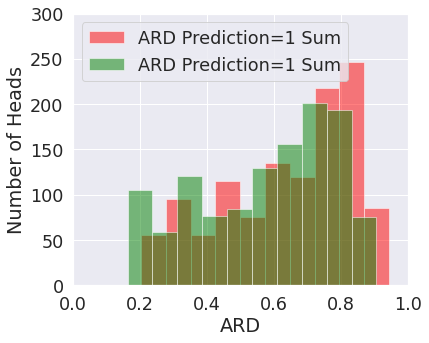

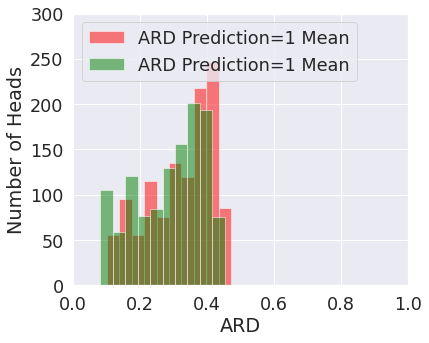

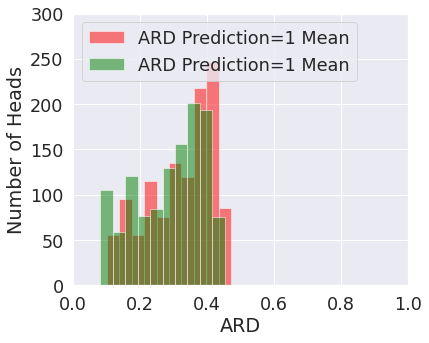

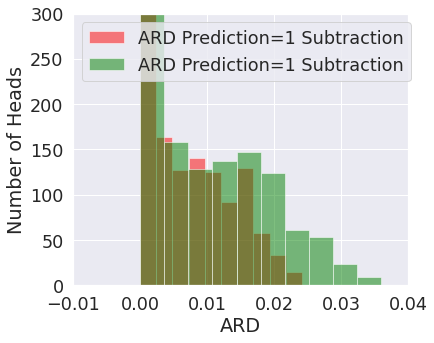

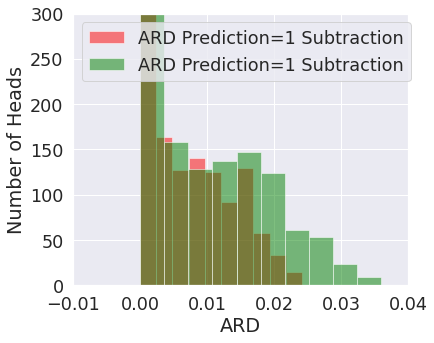

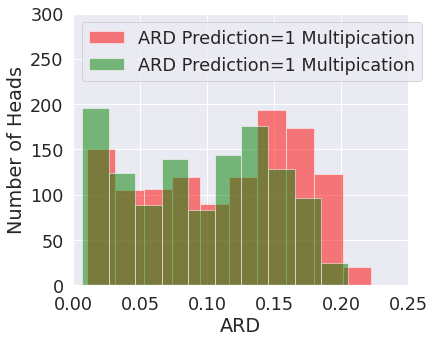

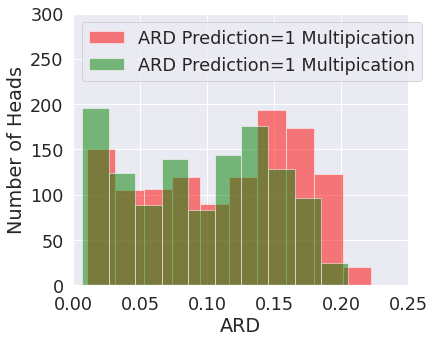

In [1324]:
plot_hist_from_prob(thin_unified_all_models_results, 'glob',True, "1",agg_type='Sum', x_lim=(0.0,1.0), y_lim=(0,300)) 
plot_hist_from_prob(thin_unified_all_models_results, 'glob',True, "0",agg_type='Sum', x_lim=(0.0,1.0), y_lim=(0,300)) 
plot_hist_from_prob(thin_unified_all_models_results, 'glob',True, "1",agg_type='Mean', x_lim=(0.0,1.0), y_lim=(0,300)) 
plot_hist_from_prob(thin_unified_all_models_results, 'glob',True, "0",agg_type='Mean', x_lim=(0.0,1.0), y_lim=(0,300)) 
plot_hist_from_prob(thin_unified_all_models_results, 'glob',True, "1",agg_type='Subtraction', x_lim=(-0.01,0.04), y_lim=(0,300)) 
plot_hist_from_prob(thin_unified_all_models_results, 'glob',True, "0",agg_type='Subtraction', x_lim=(-0.01,0.04), y_lim=(0,300)) 
plot_hist_from_prob(thin_unified_all_models_results, 'glob',True, "1",agg_type='Multipication', x_lim=(0.0,0.25), y_lim=(0,300)) 
plot_hist_from_prob(thin_unified_all_models_results, 'glob',True, "0",agg_type='Multipication', x_lim=(0.0,0.25), y_lim=(0,300)) 